In [1]:
import os
import torch
import torchaudio
torchaudio.set_audio_backend("sox_io")
import pandas as pd
import numpy as np
import torch.nn.functional as F
import random
import scipy
import math
from scipy import signal
import librosa.display
import torch.nn as nn
from torch.utils.data import DataLoader

GAMMA = 3.33
DATA = 'emodb_LMS'
LAYERS = 2
ROOT = './Dataset/{}'.format(DATA)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
MODEL_PATH = './model/{}_DANN_{}L-CNN-GRU_DAP{}_CV'.format(DATA,LAYERS,GAMMA)
NPARR_PATH = './array/{}_DANN_{}L-CNN-GRU_DAP{}_CV accuracies.npz'.format(DATA,LAYERS,GAMMA)

/home/bryan/miniconda3/envs/FYP/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def set_seed(sd):
    np.random.seed(sd)
    random.seed(sd)
    random.Random(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set to:{}".format(sd))
# also set worker_init_fn=np.random.seed(0),num_workers=0 in dataloader   

set_seed(42)

Seed set to:42


## 1. CV Dataset for EMODB

In [3]:
class EmoDBDataset2(object):
    """
        Create a Dataset for EmoDB. Each item is a tuple of the form:
        (feature, sample_rate, emotion, speaker)
    """
    _emotions = { 'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6 } 
    # W = anger, L = boredom, E = disgust, A = anxiety/fear, F = happiness, T = sadness, N = neutral
    
    _speaker = {'03': 0, '08': 1, '09': 2,'10': 3,'11': 4,'12': 5,'13': 6,'14': 7,'15': 8,'16': 9}

    def __init__(self, root, cv_index, split):
        """
        Args:
            root (string): Directory containing the features files
            split(string): Either train, validate or test set
        """
        self.root = root
        self.data = []
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])
        self.cv = { 0: (['12','13','03','08','10','14'],['15','09'],['11','16']),
                    1: (['15','09','03','08','10','14'],['11','16'],['12','13']),
                    2: (['15','09','11','16','10','14'],['12','13'],['03','08']),
                    3: (['15','09','11','16','12','13'],['03','08'],['10','14']),
                    4: (['11','16','12','13','03','08'],['10','14'],['15','09'])
                  }

        # Iterate through all audio files
        for root, dirs, files in os.walk(root):
            for file in files:
                
#                 Every utterance is named according to the same scheme:
#                 Positions 1-2: speaker_id; 
#                 Positions 3-5: code for text; 
#                 Position 6: emotion; 
#                 Position 7: if there are more than two versions, these are numbered a, b, c
                
#                 03 - male, 31 years old
#                 08 - female, 34 years
#                 09 - female, 21 years
#                 10 - male, 32 years
#                 11 - male, 26 years
#                 12 - male, 30 years
#                 13 - female, 32 years
#                 14 - female, 35 years
#                 15 - male, 25 years
#                 16 - female, 31 years
                
                if split == 'train':
                    if file[0:2] in self.cv[cv_index][0]:
                        self.data.append([file[0:2], file[5], file])
                elif split == 'validate':
                    if file[0:2] in self.cv[cv_index][1]:
                        self.data.append([file[0:2], file[5], file])
                elif split == 'test':
                    if file[0:2] in self.cv[cv_index][2]:
                        self.data.append([file[0:2], file[5], file])
                else:
                    print("Error: Split can only be train, validate or test!")
                        
                #self.data.append([file[0:2], file[5], file])

        # Convert data to pandas dataframe
        self.df = pd.DataFrame(self.data, columns=['Speaker', 'Emotion', 'File'])

        # Map emotion labels to numeric values
        self.df['Emotion'] = self.df['Emotion'].map(self._emotions).astype(np.long)
        self.df['Speaker'] = self.df['Speaker'].map(self._speaker).astype(np.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        file_name = os.path.join(self.root, self.df.loc[idx, 'File'])
        feature = torch.load(file_name)
        emotion = self.df.loc[idx, 'Emotion']
        speaker = self.df.loc[idx, 'Speaker']
        
        # return a tuple instead of a dictionary
        sample = (feature,emotion,speaker)

        return sample

In [4]:
# Initialize RavdessDataset
emodb_dataset_train = EmoDBDataset2(ROOT,cv_index = 4,split= 'train')
emodb_dataset_test = EmoDBDataset2(ROOT,cv_index = 4,split= 'test')
emodb_dataset_validate = EmoDBDataset2(ROOT,cv_index = 4, split= 'validate')

# To view dataframe, uncomment below: 
emodb_dataset_train.df

,Speaker,Emotion,File
0,0,0,03a07Wc.pt
1,1,4,08b09Fd.pt
2,6,5,13a07Tc.pt
3,9,2,16a05Ea.pt
4,6,4,13b09Fc.pt
...,...,...,...
324,9,1,16b01La.pt
325,0,3,03b02Aa.pt
326,9,3,16b01Aa.pt
327,9,5,16a07Td.pt


In [5]:
# from torch.utils.data import DataLoader
# TRAIN_BATCH_SIZE = 16
# VALIDATE_BATCH_SIZE = len(emodb_dataset_validate)
# TEST_BATCH_SIZE = len(emodb_dataset_test)
# emodb_train_loader = DataLoader(dataset=emodb_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# emodb_validate_loader = DataLoader(dataset=emodb_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)
# emodb_test_loader = DataLoader(dataset=emodb_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=2, pin_memory=True)

In [6]:
# next(iter(emodb_train_loader))

## 2. Network Architectures and Helper Functions

### 2.1 Network Architectures

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        # For same padding, P = ((S-1)*W-S+F)/2, with F = filter size, S = stride. If stride = 1, P = (F-1)/2
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, 2),padding=1,bias=False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2, 2),padding=1,bias= False),  
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  
                     
        )
        
        self.GRU = nn.GRU(input_size= 2048, hidden_size = 256 ,batch_first = True, bidirectional = True) #128
        self.global_average_pooling = nn.AdaptiveAvgPool2d((8,8))
        self.FC = nn.Linear(in_features = 8 * 8, out_features = 512) 
        
        
    def forward(self,x):
        x = self.conv_layers(x)
        # print("1-LFLB shape: {}".format(x.shape))                     # batch_size, c_out, freq, time since we are using spectogram
        x = x.view(x.size(0),-1,x.size(3)) 
        # print("Batch size, features, seq shape: {}".format(x.shape))  # batch_size, features= c_out* freq , seq_len= time
        x = x.permute(0,2,1)
        # print("Batch size, seq, features shape: {}".format(x.shape))  # batch_size, seq, features
        output, hn = self.GRU(x)
        # print("GRU output shape: {}".format(output.shape))                # batch_size, seq, hidden size * 2 
        x = self.global_average_pooling(output)
        # print("Shape after global average pooling:{}".format(x.shape))
        x = torch.flatten(x,start_dim=1)
        # print("Shape after flattening:{}".format(x.shape))
        x = self.FC(x)
        # print("FC shape: {}".format(x.shape))

        return x


In [8]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 7),

        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


In [9]:
class SpeakerClassifier(nn.Module):
    def __init__(self):
        super(SpeakerClassifier,self).__init__()
        self.label_classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout2d(p=0.5),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10),
        )
        
    def forward(self,x):
        x = self.label_classifier(x)
        return F.softmax(x)


### 2.2 Helper Functions

In [10]:
import numpy as np

def domain_adaptation_parameter(p):
    lambda_p = 2. / (1. + np.exp(-GAMMA*p)) - 1
    return lambda_p

In [11]:
def save_parameters(PATH):
    torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'emotion_classifier_state_dict': emotion_classifier.state_dict(),
                'speaker_classifier_state_dict': speaker_classifier.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'emotion_optimizer_state_dict': emotion_optimizer.state_dict(),
                'speaker_optimizer_state_dict': speaker_optimizer.state_dict(),
                }, PATH)
    print("Models' parameters and optimisers' parameters saved.")

In [12]:
def save_accuracies_and_losses(PATH):
    np.savez(PATH, 
         emoClassLoss = fold_emotion_class_losses,
         emoTrain_acc = fold_emotion_training_accuracies, 
         emoValidate_acc = fold_emotion_validating_accuracies,
         spkClassLoss = fold_speaker_class_losses,
         spkTrain_acc = fold_speaker_training_accuracies,
         spkValidate_acc = fold_speaker_validating_accuracies,
        
    )

## 4. Model Training

In [13]:
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import pylab as plt

# Read this to understand how GRL works: 
# https://christineai.blog/category/domain-adaptation/

FOLDS = 5
EPOCHS = 100

############### To comment this section out if disrupted #############
fold_emotion_class_losses = np.zeros((FOLDS,EPOCHS))
fold_emotion_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_emotion_validating_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_class_losses = np.zeros((FOLDS,EPOCHS))
fold_speaker_training_accuracies = np.zeros((FOLDS,EPOCHS))
fold_speaker_validating_accuracies = np.zeros((FOLDS,EPOCHS))


######### To uncomment if trying to continue disrupted training ######
# fold_emotion_class_losses, fold_emotion_training_accuracies, fold_emotion_validating_accuracies， fold_speaker_class_losses，fold_speaker_training_accuracies，fold_speaker_validating_accuracies= np.load(NPARR_PATH)

###################################################################

# 5-fold cross validation
for fold in range(0,FOLDS):

    # Selecting CPU or GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # DEVICE = torch.device("cpu")

    # Selecting the type of encoder, label classifier
    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE).train()
    
#     encoder = nn.DataParallel(encoder)
#     emotion_classifier = nn.DataParallel(emotion_classifier)
#     speaker_classifier = nn.DataParallel(speaker_classifier)

    # Optimizer 
    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())

    cross_entropy_loss = nn.CrossEntropyLoss().to(DEVICE)
    
    emodb_dataset_train = EmoDBDataset2(ROOT,cv_index = fold ,split= 'train')
    emodb_dataset_test = EmoDBDataset2(ROOT,cv_index = fold, split= 'test')
    emodb_dataset_validate = EmoDBDataset2(ROOT ,cv_index = fold, split= 'validate')
    
    # DANN should be trained on labelled data from the source domain and unlabelled data from the target domain
    TRAIN_BATCH_SIZE = 32
    emodb_train_loader = DataLoader(dataset=emodb_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=True,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    # For evaluation purposes
    VALIDATE_BATCH_SIZE = len(emodb_dataset_validate)
    emodb_validate_loader = DataLoader(dataset=emodb_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=4, pin_memory= True)
    
    epoch_emotion_class_losses = []
    emotion_training_accuracies = []
    emotion_validating_accuracies = []

    epoch_speaker_class_losses = []
    speaker_training_accuracies = []
    speaker_validating_accuracies = []

    STEP = 0
    for epoch in range(EPOCHS):
        print("\nCurrent Fold: {} | Epoch: {}".format(fold, epoch))

        completed_start_steps = epoch * len(emodb_train_loader)
        total_steps = EPOCHS * len(emodb_train_loader)

        batch_emotion_class_losses = []
        batch_speaker_class_losses = []


        for batch_idx, (feature, emotion, speaker) in enumerate(emodb_train_loader):

            # Assigned to DEVICE. 
            features, emotion, speaker = feature.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE)
            
            # Computing the training progress
            p = (batch_idx + completed_start_steps) / total_steps
            lambda_p = domain_adaptation_parameter(p)

            # Calculate speaker and emotion classification prediction 
            conv_features = encoder(features)
            emotion_preds = emotion_classifier(conv_features)
            emotion_class_loss = cross_entropy_loss(emotion_preds, emotion)
            speaker_preds = speaker_classifier(conv_features)
            speaker_class_loss = cross_entropy_loss(speaker_preds, speaker)

            # Calculate total loss
            total_loss = emotion_class_loss - lambda_p * speaker_class_loss 

            # Clear the gradient to prevent gradient accumulation
            encoder.zero_grad(set_to_none= True)
            emotion_classifier.zero_grad(set_to_none= True)
            speaker_classifier.zero_grad(set_to_none= True)

            # Computing the gradient
            total_loss.backward()

            # Update the weight
            emotion_optimizer.step()
            speaker_optimizer.step()
            encoder_optimizer.step()

            batch_emotion_class_losses.append(emotion_class_loss.detach())
            batch_speaker_class_losses.append(speaker_class_loss.detach())


        # Enter evaluation mode at the end of each epoch
        encoder.eval()
        emotion_classifier.eval()
        speaker_classifier.eval()

        emotion_training_correct, emotion_validating_correct, speaker_training_correct, speaker_validating_correct = 0 , 0 , 0 , 0

        with torch.no_grad():

        # 1. Training Classification
          for index, (features, emotion, speaker) in enumerate(emodb_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_training_correct += (emotion_preds == emotion).sum() 
            speaker_training_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_training_accuracy = emotion_training_correct.item()/(len(emodb_train_loader)*TRAIN_BATCH_SIZE)
          emotion_training_accuracies.append(emotion_training_accuracy)
          speaker_training_accuracy = speaker_training_correct.item()/(len(emodb_train_loader)*TRAIN_BATCH_SIZE)
          speaker_training_accuracies.append(speaker_training_accuracy)
          print("Emotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(emotion_training_correct,(len(emodb_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
          print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(speaker_training_correct,(len(emodb_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100))

        # 2. Validating Classification
          for index, (features, emotion, speaker) in enumerate(emodb_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            emotion_validating_correct += (emotion_preds == emotion).sum() 
            speaker_validating_correct += (speaker_preds == speaker).sum() 
          #source_accuracy = torch.true_divide(source_correct, len(svhn_test_loader.dataset))
          emotion_validating_accuracy = emotion_validating_correct.item()/(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE)
          emotion_validating_accuracies.append(emotion_validating_accuracy)
          speaker_validating_accuracy = speaker_validating_correct.item()/(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE)
          speaker_validating_accuracies.append(speaker_validating_accuracy)
          print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(emotion_validating_correct,(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
          print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(speaker_validating_correct,(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100))

          if (len(emotion_validating_accuracies)> 1 and emotion_validating_accuracy >= max(emotion_validating_accuracies[:-1])):
                save_parameters(MODEL_PATH + 'fold' + str(fold))


        encoder.train()
        emotion_classifier.train()
        speaker_classifier.train()


        epoch_emotion_class_loss = torch.mean(torch.stack(batch_emotion_class_losses), dim=0)
        epoch_emotion_class_losses.append(epoch_emotion_class_loss)
        epoch_speaker_class_loss = torch.mean(torch.stack(batch_speaker_class_losses), dim=0)
        epoch_speaker_class_losses.append(epoch_speaker_class_loss)
        
    fold_emotion_class_losses[fold] = epoch_emotion_class_losses
    fold_emotion_training_accuracies[fold] = emotion_training_accuracies
    fold_emotion_validating_accuracies[fold] = emotion_validating_accuracies
    fold_speaker_class_losses[fold] = epoch_speaker_class_losses
    fold_speaker_training_accuracies[fold] = speaker_training_accuracies
    fold_speaker_validating_accuracies[fold] = speaker_validating_accuracies
    
    save_accuracies_and_losses(NPARR_PATH)
    
    
    



Current Fold: 0 | Epoch: 0


Emotion Training Correct: 71/288 
Emotion Training Accuracy: 24.65278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/99 
Emotion Validating Accuracy: 26.26263%
Speaker Validating Correct: 56/99 
Speaker Validating Accuracy: 56.56566%

Current Fold: 0 | Epoch: 1


Emotion Training Correct: 79/288 
Emotion Training Accuracy: 27.43056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 56/99 
Speaker Validating Accuracy: 56.56566%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 2


Emotion Training Correct: 94/288 
Emotion Training Accuracy: 32.63889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/99 
Emotion Validating Accuracy: 22.22222%
Speaker Validating Correct: 57/99 
Speaker Validating Accuracy: 57.57576%

Current Fold: 0 | Epoch: 3


Emotion Training Correct: 97/288 
Emotion Training Accuracy: 33.68056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 55/99 
Speaker Validating Accuracy: 55.55556%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 4


Emotion Training Correct: 91/288 
Emotion Training Accuracy: 31.59722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 47/99 
Speaker Validating Accuracy: 47.47475%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 5


Emotion Training Correct: 94/288 
Emotion Training Accuracy: 32.63889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 6


Emotion Training Correct: 90/288 
Emotion Training Accuracy: 31.25000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%
Models' parameters and optimisers' parameters saved.



Current Fold: 0 | Epoch: 7


Emotion Training Correct: 86/288 
Emotion Training Accuracy: 29.86111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/99 
Emotion Validating Accuracy: 26.26263%
Speaker Validating Correct: 45/99 
Speaker Validating Accuracy: 45.45455%

Current Fold: 0 | Epoch: 8


Emotion Training Correct: 99/288 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 9


Emotion Training Correct: 109/288 
Emotion Training Accuracy: 37.84722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/99 
Emotion Validating Accuracy: 30.30303%
Speaker Validating Correct: 51/99 
Speaker Validating Accuracy: 51.51515%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 10


Emotion Training Correct: 100/288 
Emotion Training Accuracy: 34.72222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/99 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 53/99 
Speaker Validating Accuracy: 53.53535%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 11


Emotion Training Correct: 116/288 
Emotion Training Accuracy: 40.27778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/99 
Emotion Validating Accuracy: 36.36364%
Speaker Validating Correct: 52/99 
Speaker Validating Accuracy: 52.52525%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 12


Emotion Training Correct: 107/288 
Emotion Training Accuracy: 37.15278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/99 
Emotion Validating Accuracy: 34.34343%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 13


Emotion Training Correct: 119/288 
Emotion Training Accuracy: 41.31944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/99 
Emotion Validating Accuracy: 39.39394%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 14


Emotion Training Correct: 125/288 
Emotion Training Accuracy: 43.40278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%

Current Fold: 0 | Epoch: 15


Emotion Training Correct: 123/288 
Emotion Training Accuracy: 42.70833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/99 
Emotion Validating Accuracy: 39.39394%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 16


Emotion Training Correct: 113/288 
Emotion Training Accuracy: 39.23611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/99 
Emotion Validating Accuracy: 31.31313%
Speaker Validating Correct: 50/99 
Speaker Validating Accuracy: 50.50505%

Current Fold: 0 | Epoch: 17


Emotion Training Correct: 124/288 
Emotion Training Accuracy: 43.05556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/99 
Emotion Validating Accuracy: 40.40404%
Speaker Validating Correct: 51/99 
Speaker Validating Accuracy: 51.51515%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 18


Emotion Training Correct: 116/288 
Emotion Training Accuracy: 40.27778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%
Speaker Validating Correct: 50/99 
Speaker Validating Accuracy: 50.50505%

Current Fold: 0 | Epoch: 19


Emotion Training Correct: 120/288 
Emotion Training Accuracy: 41.66667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/99 
Emotion Validating Accuracy: 34.34343%
Speaker Validating Correct: 32/99 
Speaker Validating Accuracy: 32.32323%

Current Fold: 0 | Epoch: 20


Emotion Training Correct: 108/288 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/99 
Emotion Validating Accuracy: 34.34343%
Speaker Validating Correct: 35/99 
Speaker Validating Accuracy: 35.35354%

Current Fold: 0 | Epoch: 21


Emotion Training Correct: 118/288 
Emotion Training Accuracy: 40.97222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/99 
Emotion Validating Accuracy: 38.38384%
Speaker Validating Correct: 46/99 
Speaker Validating Accuracy: 46.46465%

Current Fold: 0 | Epoch: 22


Emotion Training Correct: 135/288 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/99 
Emotion Validating Accuracy: 46.46465%
Speaker Validating Correct: 50/99 
Speaker Validating Accuracy: 50.50505%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 23


Emotion Training Correct: 93/288 
Emotion Training Accuracy: 32.29167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/99 
Emotion Validating Accuracy: 29.29293%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 24


Emotion Training Correct: 130/288 
Emotion Training Accuracy: 45.13889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%

Current Fold: 0 | Epoch: 25


Emotion Training Correct: 72/288 
Emotion Training Accuracy: 25.00000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/99 
Emotion Validating Accuracy: 23.23232%
Speaker Validating Correct: 38/99 
Speaker Validating Accuracy: 38.38384%

Current Fold: 0 | Epoch: 26


Emotion Training Correct: 94/288 
Emotion Training Accuracy: 32.63889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/99 
Emotion Validating Accuracy: 28.28283%
Speaker Validating Correct: 32/99 
Speaker Validating Accuracy: 32.32323%

Current Fold: 0 | Epoch: 27


Emotion Training Correct: 135/288 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%

Current Fold: 0 | Epoch: 28


Emotion Training Correct: 155/288 
Emotion Training Accuracy: 53.81944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/99 
Emotion Validating Accuracy: 54.54545%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 29


Emotion Training Correct: 149/288 
Emotion Training Accuracy: 51.73611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/99 
Emotion Validating Accuracy: 41.41414%
Speaker Validating Correct: 53/99 
Speaker Validating Accuracy: 53.53535%

Current Fold: 0 | Epoch: 30


Emotion Training Correct: 146/288 
Emotion Training Accuracy: 50.69444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/99 
Emotion Validating Accuracy: 42.42424%
Speaker Validating Correct: 52/99 
Speaker Validating Accuracy: 52.52525%

Current Fold: 0 | Epoch: 31


Emotion Training Correct: 73/288 
Emotion Training Accuracy: 25.34722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 17/99 
Emotion Validating Accuracy: 17.17172%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 32


Emotion Training Correct: 176/288 
Emotion Training Accuracy: 61.11111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/99 
Emotion Validating Accuracy: 54.54545%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%
Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 33


Emotion Training Correct: 155/288 
Emotion Training Accuracy: 53.81944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/99 
Emotion Validating Accuracy: 52.52525%
Speaker Validating Correct: 47/99 
Speaker Validating Accuracy: 47.47475%

Current Fold: 0 | Epoch: 34


Emotion Training Correct: 164/288 
Emotion Training Accuracy: 56.94444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 35


Emotion Training Correct: 121/288 
Emotion Training Accuracy: 42.01389%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/99 
Emotion Validating Accuracy: 38.38384%
Speaker Validating Correct: 39/99 
Speaker Validating Accuracy: 39.39394%

Current Fold: 0 | Epoch: 36


Emotion Training Correct: 110/288 
Emotion Training Accuracy: 38.19444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/99 
Emotion Validating Accuracy: 26.26263%
Speaker Validating Correct: 41/99 
Speaker Validating Accuracy: 41.41414%

Current Fold: 0 | Epoch: 37


Emotion Training Correct: 166/288 
Emotion Training Accuracy: 57.63889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%
Speaker Validating Correct: 23/99 
Speaker Validating Accuracy: 23.23232%

Current Fold: 0 | Epoch: 38


Emotion Training Correct: 143/288 
Emotion Training Accuracy: 49.65278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/99 
Emotion Validating Accuracy: 40.40404%
Speaker Validating Correct: 28/99 
Speaker Validating Accuracy: 28.28283%

Current Fold: 0 | Epoch: 39


Emotion Training Correct: 149/288 
Emotion Training Accuracy: 51.73611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/99 
Emotion Validating Accuracy: 39.39394%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 40


Emotion Training Correct: 172/288 
Emotion Training Accuracy: 59.72222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 45/99 
Speaker Validating Accuracy: 45.45455%

Current Fold: 0 | Epoch: 41


Emotion Training Correct: 186/288 
Emotion Training Accuracy: 64.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/99 
Emotion Validating Accuracy: 54.54545%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 42


Emotion Training Correct: 129/288 
Emotion Training Accuracy: 44.79167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%
Speaker Validating Correct: 53/99 
Speaker Validating Accuracy: 53.53535%

Current Fold: 0 | Epoch: 43


Emotion Training Correct: 129/288 
Emotion Training Accuracy: 44.79167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/99 
Emotion Validating Accuracy: 39.39394%
Speaker Validating Correct: 53/99 
Speaker Validating Accuracy: 53.53535%

Current Fold: 0 | Epoch: 44


Emotion Training Correct: 160/288 
Emotion Training Accuracy: 55.55556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/99 
Emotion Validating Accuracy: 43.43434%
Speaker Validating Correct: 51/99 
Speaker Validating Accuracy: 51.51515%

Current Fold: 0 | Epoch: 45


Emotion Training Correct: 133/288 
Emotion Training Accuracy: 46.18056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/99 
Emotion Validating Accuracy: 48.48485%
Speaker Validating Correct: 45/99 
Speaker Validating Accuracy: 45.45455%

Current Fold: 0 | Epoch: 46


Emotion Training Correct: 169/288 
Emotion Training Accuracy: 58.68056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/99 
Emotion Validating Accuracy: 48.48485%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 47


Emotion Training Correct: 171/288 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/99 
Emotion Validating Accuracy: 45.45455%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 48


Emotion Training Correct: 135/288 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/99 
Emotion Validating Accuracy: 38.38384%
Speaker Validating Correct: 36/99 
Speaker Validating Accuracy: 36.36364%

Current Fold: 0 | Epoch: 49


Emotion Training Correct: 149/288 
Emotion Training Accuracy: 51.73611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 37/99 
Speaker Validating Accuracy: 37.37374%

Current Fold: 0 | Epoch: 50


Emotion Training Correct: 159/288 
Emotion Training Accuracy: 55.20833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/99 
Emotion Validating Accuracy: 42.42424%
Speaker Validating Correct: 39/99 
Speaker Validating Accuracy: 39.39394%

Current Fold: 0 | Epoch: 51


Emotion Training Correct: 165/288 
Emotion Training Accuracy: 57.29167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/99 
Emotion Validating Accuracy: 47.47475%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 52


Emotion Training Correct: 147/288 
Emotion Training Accuracy: 51.04167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/99 
Emotion Validating Accuracy: 42.42424%
Speaker Validating Correct: 50/99 
Speaker Validating Accuracy: 50.50505%

Current Fold: 0 | Epoch: 53


Emotion Training Correct: 136/288 
Emotion Training Accuracy: 47.22222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/99 
Emotion Validating Accuracy: 39.39394%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 54


Emotion Training Correct: 182/288 
Emotion Training Accuracy: 63.19444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/99 
Emotion Validating Accuracy: 46.46465%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 55


Emotion Training Correct: 114/288 
Emotion Training Accuracy: 39.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/99 
Emotion Validating Accuracy: 36.36364%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%

Current Fold: 0 | Epoch: 56


Emotion Training Correct: 78/288 
Emotion Training Accuracy: 27.08333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 17/99 
Emotion Validating Accuracy: 17.17172%
Speaker Validating Correct: 41/99 
Speaker Validating Accuracy: 41.41414%

Current Fold: 0 | Epoch: 57


Emotion Training Correct: 161/288 
Emotion Training Accuracy: 55.90278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 58


Emotion Training Correct: 167/288 
Emotion Training Accuracy: 57.98611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 39/99 
Speaker Validating Accuracy: 39.39394%

Current Fold: 0 | Epoch: 59


Emotion Training Correct: 189/288 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/99 
Emotion Validating Accuracy: 51.51515%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%

Current Fold: 0 | Epoch: 60


Emotion Training Correct: 182/288 
Emotion Training Accuracy: 63.19444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/99 
Emotion Validating Accuracy: 56.56566%
Speaker Validating Correct: 45/99 
Speaker Validating Accuracy: 45.45455%


Models' parameters and optimisers' parameters saved.

Current Fold: 0 | Epoch: 61


Emotion Training Correct: 169/288 
Emotion Training Accuracy: 58.68056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%

Current Fold: 0 | Epoch: 62


Emotion Training Correct: 142/288 
Emotion Training Accuracy: 49.30556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 63


Emotion Training Correct: 178/288 
Emotion Training Accuracy: 61.80556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/99 
Emotion Validating Accuracy: 47.47475%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 64


Emotion Training Correct: 190/288 
Emotion Training Accuracy: 65.97222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/99 
Emotion Validating Accuracy: 46.46465%
Speaker Validating Correct: 47/99 
Speaker Validating Accuracy: 47.47475%

Current Fold: 0 | Epoch: 65


Emotion Training Correct: 132/288 
Emotion Training Accuracy: 45.83333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/99 
Emotion Validating Accuracy: 34.34343%
Speaker Validating Correct: 51/99 
Speaker Validating Accuracy: 51.51515%

Current Fold: 0 | Epoch: 66


Emotion Training Correct: 101/288 
Emotion Training Accuracy: 35.06944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/99 
Emotion Validating Accuracy: 21.21212%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 67


Emotion Training Correct: 118/288 
Emotion Training Accuracy: 40.97222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/99 
Emotion Validating Accuracy: 35.35354%
Speaker Validating Correct: 41/99 
Speaker Validating Accuracy: 41.41414%

Current Fold: 0 | Epoch: 68


Emotion Training Correct: 93/288 
Emotion Training Accuracy: 32.29167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 27/99 
Emotion Validating Accuracy: 27.27273%
Speaker Validating Correct: 29/99 
Speaker Validating Accuracy: 29.29293%

Current Fold: 0 | Epoch: 69


Emotion Training Correct: 92/288 
Emotion Training Accuracy: 31.94444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 20/99 
Emotion Validating Accuracy: 20.20202%
Speaker Validating Correct: 2/99 
Speaker Validating Accuracy: 2.02020%

Current Fold: 0 | Epoch: 70


Emotion Training Correct: 102/288 
Emotion Training Accuracy: 35.41667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/99 
Emotion Validating Accuracy: 34.34343%
Speaker Validating Correct: 38/99 
Speaker Validating Accuracy: 38.38384%

Current Fold: 0 | Epoch: 71


Emotion Training Correct: 183/288 
Emotion Training Accuracy: 63.54167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/99 
Emotion Validating Accuracy: 48.48485%
Speaker Validating Correct: 39/99 
Speaker Validating Accuracy: 39.39394%

Current Fold: 0 | Epoch: 72


Emotion Training Correct: 162/288 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/99 
Emotion Validating Accuracy: 47.47475%
Speaker Validating Correct: 30/99 
Speaker Validating Accuracy: 30.30303%

Current Fold: 0 | Epoch: 73


Emotion Training Correct: 142/288 
Emotion Training Accuracy: 49.30556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/99 
Emotion Validating Accuracy: 43.43434%
Speaker Validating Correct: 33/99 
Speaker Validating Accuracy: 33.33333%

Current Fold: 0 | Epoch: 74


Emotion Training Correct: 138/288 
Emotion Training Accuracy: 47.91667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/99 
Emotion Validating Accuracy: 40.40404%
Speaker Validating Correct: 29/99 
Speaker Validating Accuracy: 29.29293%

Current Fold: 0 | Epoch: 75


Emotion Training Correct: 148/288 
Emotion Training Accuracy: 51.38889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/99 
Emotion Validating Accuracy: 46.46465%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%

Current Fold: 0 | Epoch: 76


Emotion Training Correct: 130/288 
Emotion Training Accuracy: 45.13889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/99 
Emotion Validating Accuracy: 37.37374%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 77


Emotion Training Correct: 89/288 
Emotion Training Accuracy: 30.90278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/99 
Emotion Validating Accuracy: 25.25253%
Speaker Validating Correct: 51/99 
Speaker Validating Accuracy: 51.51515%

Current Fold: 0 | Epoch: 78


Emotion Training Correct: 98/288 
Emotion Training Accuracy: 34.02778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/99 
Emotion Validating Accuracy: 30.30303%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 79


Emotion Training Correct: 140/288 
Emotion Training Accuracy: 48.61111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/99 
Emotion Validating Accuracy: 41.41414%
Speaker Validating Correct: 46/99 
Speaker Validating Accuracy: 46.46465%

Current Fold: 0 | Epoch: 80


Emotion Training Correct: 176/288 
Emotion Training Accuracy: 61.11111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/99 
Emotion Validating Accuracy: 40.40404%
Speaker Validating Correct: 45/99 
Speaker Validating Accuracy: 45.45455%

Current Fold: 0 | Epoch: 81


Emotion Training Correct: 184/288 
Emotion Training Accuracy: 63.88889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/99 
Emotion Validating Accuracy: 43.43434%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 82


Emotion Training Correct: 176/288 
Emotion Training Accuracy: 61.11111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/99 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 41/99 
Speaker Validating Accuracy: 41.41414%

Current Fold: 0 | Epoch: 83


Emotion Training Correct: 172/288 
Emotion Training Accuracy: 59.72222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/99 
Emotion Validating Accuracy: 47.47475%
Speaker Validating Correct: 40/99 
Speaker Validating Accuracy: 40.40404%

Current Fold: 0 | Epoch: 84


Emotion Training Correct: 136/288 
Emotion Training Accuracy: 47.22222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/99 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%

Current Fold: 0 | Epoch: 85


Emotion Training Correct: 179/288 
Emotion Training Accuracy: 62.15278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/99 
Emotion Validating Accuracy: 46.46465%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 86


Emotion Training Correct: 182/288 
Emotion Training Accuracy: 63.19444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/99 
Emotion Validating Accuracy: 55.55556%
Speaker Validating Correct: 47/99 
Speaker Validating Accuracy: 47.47475%

Current Fold: 0 | Epoch: 87


Emotion Training Correct: 183/288 
Emotion Training Accuracy: 63.54167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/99 
Emotion Validating Accuracy: 45.45455%
Speaker Validating Correct: 41/99 
Speaker Validating Accuracy: 41.41414%

Current Fold: 0 | Epoch: 88


Emotion Training Correct: 202/288 
Emotion Training Accuracy: 70.13889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/99 
Emotion Validating Accuracy: 54.54545%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%

Current Fold: 0 | Epoch: 89


Emotion Training Correct: 172/288 
Emotion Training Accuracy: 59.72222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/99 
Emotion Validating Accuracy: 48.48485%
Speaker Validating Correct: 45/99 
Speaker Validating Accuracy: 45.45455%

Current Fold: 0 | Epoch: 90


Emotion Training Correct: 178/288 
Emotion Training Accuracy: 61.80556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/99 
Emotion Validating Accuracy: 49.49495%
Speaker Validating Correct: 49/99 
Speaker Validating Accuracy: 49.49495%

Current Fold: 0 | Epoch: 91


Emotion Training Correct: 116/288 
Emotion Training Accuracy: 40.27778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/99 
Emotion Validating Accuracy: 35.35354%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 92


Emotion Training Correct: 114/288 
Emotion Training Accuracy: 39.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/99 
Emotion Validating Accuracy: 34.34343%
Speaker Validating Correct: 51/99 
Speaker Validating Accuracy: 51.51515%

Current Fold: 0 | Epoch: 93


Emotion Training Correct: 155/288 
Emotion Training Accuracy: 53.81944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/99 
Emotion Validating Accuracy: 41.41414%
Speaker Validating Correct: 42/99 
Speaker Validating Accuracy: 42.42424%

Current Fold: 0 | Epoch: 94


Emotion Training Correct: 160/288 
Emotion Training Accuracy: 55.55556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/99 
Emotion Validating Accuracy: 46.46465%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 95


Emotion Training Correct: 119/288 
Emotion Training Accuracy: 41.31944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/99 
Emotion Validating Accuracy: 32.32323%
Speaker Validating Correct: 32/99 
Speaker Validating Accuracy: 32.32323%

Current Fold: 0 | Epoch: 96


Emotion Training Correct: 176/288 
Emotion Training Accuracy: 61.11111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/99 
Emotion Validating Accuracy: 52.52525%
Speaker Validating Correct: 44/99 
Speaker Validating Accuracy: 44.44444%

Current Fold: 0 | Epoch: 97


Emotion Training Correct: 125/288 
Emotion Training Accuracy: 43.40278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/99 
Emotion Validating Accuracy: 31.31313%
Speaker Validating Correct: 27/99 
Speaker Validating Accuracy: 27.27273%

Current Fold: 0 | Epoch: 98


Emotion Training Correct: 174/288 
Emotion Training Accuracy: 60.41667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/99 
Emotion Validating Accuracy: 43.43434%
Speaker Validating Correct: 48/99 
Speaker Validating Accuracy: 48.48485%

Current Fold: 0 | Epoch: 99


Emotion Training Correct: 185/288 
Emotion Training Accuracy: 64.23611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/99 
Emotion Validating Accuracy: 45.45455%
Speaker Validating Correct: 31/99 
Speaker Validating Accuracy: 31.31313%



Current Fold: 1 | Epoch: 0


Emotion Training Correct: 38/288 
Emotion Training Accuracy: 13.19444%
Speaker Training Correct: 38/288 
Speaker Training Accuracy: 13.19444%



Emotion Validating Correct: 20/126 
Emotion Validating Accuracy: 15.87302%
Speaker Validating Correct: 0/126 
Speaker Validating Accuracy: 0.00000%

Current Fold: 1 | Epoch: 1


Emotion Training Correct: 51/288 
Emotion Training Accuracy: 17.70833%
Speaker Training Correct: 11/288 
Speaker Training Accuracy: 3.81944%



Emotion Validating Correct: 22/126 
Emotion Validating Accuracy: 17.46032%
Speaker Validating Correct: 35/126 
Speaker Validating Accuracy: 27.77778%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 2


Emotion Training Correct: 72/288 
Emotion Training Accuracy: 25.00000%
Speaker Training Correct: 9/288 
Speaker Training Accuracy: 3.12500%



Emotion Validating Correct: 28/126 
Emotion Validating Accuracy: 22.22222%
Speaker Validating Correct: 52/126 
Speaker Validating Accuracy: 41.26984%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 3


Emotion Training Correct: 83/288 
Emotion Training Accuracy: 28.81944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/126 
Emotion Validating Accuracy: 24.60317%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 4


Emotion Training Correct: 84/288 
Emotion Training Accuracy: 29.16667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/126 
Emotion Validating Accuracy: 25.39683%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 5


Emotion Training Correct: 89/288 
Emotion Training Accuracy: 30.90278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/126 
Emotion Validating Accuracy: 29.36508%
Speaker Validating Correct: 50/126 
Speaker Validating Accuracy: 39.68254%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 6


Emotion Training Correct: 98/288 
Emotion Training Accuracy: 34.02778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/126 
Emotion Validating Accuracy: 30.15873%
Speaker Validating Correct: 46/126 
Speaker Validating Accuracy: 36.50794%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 7


Emotion Training Correct: 95/288 
Emotion Training Accuracy: 32.98611%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/126 
Emotion Validating Accuracy: 27.77778%
Speaker Validating Correct: 45/126 
Speaker Validating Accuracy: 35.71429%

Current Fold: 1 | Epoch: 8


Emotion Training Correct: 115/288 
Emotion Training Accuracy: 39.93056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/126 
Emotion Validating Accuracy: 30.95238%
Speaker Validating Correct: 39/126 
Speaker Validating Accuracy: 30.95238%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 9


Emotion Training Correct: 104/288 
Emotion Training Accuracy: 36.11111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/126 
Emotion Validating Accuracy: 28.57143%
Speaker Validating Correct: 58/126 
Speaker Validating Accuracy: 46.03175%

Current Fold: 1 | Epoch: 10


Emotion Training Correct: 119/288 
Emotion Training Accuracy: 41.31944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/126 
Emotion Validating Accuracy: 30.15873%
Speaker Validating Correct: 55/126 
Speaker Validating Accuracy: 43.65079%

Current Fold: 1 | Epoch: 11


Emotion Training Correct: 105/288 
Emotion Training Accuracy: 36.45833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/126 
Emotion Validating Accuracy: 30.15873%
Speaker Validating Correct: 54/126 
Speaker Validating Accuracy: 42.85714%

Current Fold: 1 | Epoch: 12


Emotion Training Correct: 127/288 
Emotion Training Accuracy: 44.09722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 60/126 
Speaker Validating Accuracy: 47.61905%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 13


Emotion Training Correct: 115/288 
Emotion Training Accuracy: 39.93056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/126 
Emotion Validating Accuracy: 31.74603%
Speaker Validating Correct: 59/126 
Speaker Validating Accuracy: 46.82540%

Current Fold: 1 | Epoch: 14


Emotion Training Correct: 114/288 
Emotion Training Accuracy: 39.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/126 
Emotion Validating Accuracy: 32.53968%
Speaker Validating Correct: 60/126 
Speaker Validating Accuracy: 47.61905%

Current Fold: 1 | Epoch: 15


Emotion Training Correct: 128/288 
Emotion Training Accuracy: 44.44444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/126 
Emotion Validating Accuracy: 32.53968%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 16


Emotion Training Correct: 115/288 
Emotion Training Accuracy: 39.93056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/126 
Emotion Validating Accuracy: 31.74603%
Speaker Validating Correct: 59/126 
Speaker Validating Accuracy: 46.82540%

Current Fold: 1 | Epoch: 17


Emotion Training Correct: 140/288 
Emotion Training Accuracy: 48.61111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 18


Emotion Training Correct: 130/288 
Emotion Training Accuracy: 45.13889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 19


Emotion Training Correct: 106/288 
Emotion Training Accuracy: 36.80556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/126 
Emotion Validating Accuracy: 31.74603%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 20


Emotion Training Correct: 135/288 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 63/126 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 21


Emotion Training Correct: 126/288 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 22


Emotion Training Correct: 142/288 
Emotion Training Accuracy: 49.30556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/126 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 23


Emotion Training Correct: 132/288 
Emotion Training Accuracy: 45.83333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 24


Emotion Training Correct: 143/288 
Emotion Training Accuracy: 49.65278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 25


Emotion Training Correct: 108/288 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/126 
Emotion Validating Accuracy: 30.95238%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%

Current Fold: 1 | Epoch: 26


Emotion Training Correct: 145/288 
Emotion Training Accuracy: 50.34722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/126 
Emotion Validating Accuracy: 35.71429%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 27


Emotion Training Correct: 135/288 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 28


Emotion Training Correct: 145/288 
Emotion Training Accuracy: 50.34722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 29


Emotion Training Correct: 132/288 
Emotion Training Accuracy: 45.83333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/126 
Emotion Validating Accuracy: 35.71429%
Speaker Validating Correct: 63/126 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 30


Emotion Training Correct: 136/288 
Emotion Training Accuracy: 47.22222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 63/126 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 31


Emotion Training Correct: 115/288 
Emotion Training Accuracy: 39.93056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/126 
Emotion Validating Accuracy: 31.74603%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 32


Emotion Training Correct: 124/288 
Emotion Training Accuracy: 43.05556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/126 
Emotion Validating Accuracy: 28.57143%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%

Current Fold: 1 | Epoch: 33


Emotion Training Correct: 115/288 
Emotion Training Accuracy: 39.93056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/126 
Emotion Validating Accuracy: 32.53968%
Speaker Validating Correct: 70/126 
Speaker Validating Accuracy: 55.55556%

Current Fold: 1 | Epoch: 34


Emotion Training Correct: 134/288 
Emotion Training Accuracy: 46.52778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/126 
Emotion Validating Accuracy: 30.95238%
Speaker Validating Correct: 69/126 
Speaker Validating Accuracy: 54.76190%

Current Fold: 1 | Epoch: 35


Emotion Training Correct: 140/288 
Emotion Training Accuracy: 48.61111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/126 
Emotion Validating Accuracy: 36.50794%
Speaker Validating Correct: 72/126 
Speaker Validating Accuracy: 57.14286%

Current Fold: 1 | Epoch: 36


Emotion Training Correct: 142/288 
Emotion Training Accuracy: 49.30556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 37


Emotion Training Correct: 134/288 
Emotion Training Accuracy: 46.52778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 38


Emotion Training Correct: 145/288 
Emotion Training Accuracy: 50.34722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/126 
Emotion Validating Accuracy: 36.50794%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 39


Emotion Training Correct: 139/288 
Emotion Training Accuracy: 48.26389%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 68/126 
Speaker Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 40


Emotion Training Correct: 146/288 
Emotion Training Accuracy: 50.69444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 70/126 
Speaker Validating Accuracy: 55.55556%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 41


Emotion Training Correct: 132/288 
Emotion Training Accuracy: 45.83333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 69/126 
Speaker Validating Accuracy: 54.76190%

Current Fold: 1 | Epoch: 42


Emotion Training Correct: 148/288 
Emotion Training Accuracy: 51.38889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 43


Emotion Training Correct: 138/288 
Emotion Training Accuracy: 47.91667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 68/126 
Speaker Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 44


Emotion Training Correct: 166/288 
Emotion Training Accuracy: 57.63889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 69/126 
Speaker Validating Accuracy: 54.76190%

Current Fold: 1 | Epoch: 45


Emotion Training Correct: 142/288 
Emotion Training Accuracy: 49.30556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 71/126 
Speaker Validating Accuracy: 56.34921%

Current Fold: 1 | Epoch: 46


Emotion Training Correct: 117/288 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/126 
Emotion Validating Accuracy: 31.74603%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 47


Emotion Training Correct: 141/288 
Emotion Training Accuracy: 48.95833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%

Current Fold: 1 | Epoch: 48


Emotion Training Correct: 134/288 
Emotion Training Accuracy: 46.52778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 70/126 
Speaker Validating Accuracy: 55.55556%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 49


Emotion Training Correct: 91/288 
Emotion Training Accuracy: 31.59722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/126 
Emotion Validating Accuracy: 30.95238%
Speaker Validating Correct: 72/126 
Speaker Validating Accuracy: 57.14286%

Current Fold: 1 | Epoch: 50


Emotion Training Correct: 87/288 
Emotion Training Accuracy: 30.20833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/126 
Emotion Validating Accuracy: 30.95238%
Speaker Validating Correct: 63/126 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 51


Emotion Training Correct: 146/288 
Emotion Training Accuracy: 50.69444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 63/126 
Speaker Validating Accuracy: 50.00000%

Current Fold: 1 | Epoch: 52


Emotion Training Correct: 153/288 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/126 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 60/126 
Speaker Validating Accuracy: 47.61905%

Current Fold: 1 | Epoch: 53


Emotion Training Correct: 101/288 
Emotion Training Accuracy: 35.06944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/126 
Emotion Validating Accuracy: 30.15873%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 54


Emotion Training Correct: 121/288 
Emotion Training Accuracy: 42.01389%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/126 
Emotion Validating Accuracy: 28.57143%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 55


Emotion Training Correct: 127/288 
Emotion Training Accuracy: 44.09722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 56


Emotion Training Correct: 171/288 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/126 
Emotion Validating Accuracy: 40.47619%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 57


Emotion Training Correct: 138/288 
Emotion Training Accuracy: 47.91667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%

Current Fold: 1 | Epoch: 58


Emotion Training Correct: 112/288 
Emotion Training Accuracy: 38.88889%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 71/126 
Speaker Validating Accuracy: 56.34921%

Current Fold: 1 | Epoch: 59


Emotion Training Correct: 142/288 
Emotion Training Accuracy: 49.30556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 73/126 
Speaker Validating Accuracy: 57.93651%

Current Fold: 1 | Epoch: 60


Emotion Training Correct: 147/288 
Emotion Training Accuracy: 51.04167%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%

Current Fold: 1 | Epoch: 61


Emotion Training Correct: 159/288 
Emotion Training Accuracy: 55.20833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 62


Emotion Training Correct: 152/288 
Emotion Training Accuracy: 52.77778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/126 
Emotion Validating Accuracy: 42.85714%
Speaker Validating Correct: 63/126 
Speaker Validating Accuracy: 50.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 63


Emotion Training Correct: 139/288 
Emotion Training Accuracy: 48.26389%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%

Current Fold: 1 | Epoch: 64


Emotion Training Correct: 158/288 
Emotion Training Accuracy: 54.86111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%

Current Fold: 1 | Epoch: 65


Emotion Training Correct: 159/288 
Emotion Training Accuracy: 55.20833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%

Current Fold: 1 | Epoch: 66


Emotion Training Correct: 175/288 
Emotion Training Accuracy: 60.76389%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 67


Emotion Training Correct: 173/288 
Emotion Training Accuracy: 60.06944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/126 
Emotion Validating Accuracy: 40.47619%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 68


Emotion Training Correct: 175/288 
Emotion Training Accuracy: 60.76389%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/126 
Emotion Validating Accuracy: 35.71429%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%

Current Fold: 1 | Epoch: 69


Emotion Training Correct: 156/288 
Emotion Training Accuracy: 54.16667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/126 
Emotion Validating Accuracy: 35.71429%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%

Current Fold: 1 | Epoch: 70


Emotion Training Correct: 173/288 
Emotion Training Accuracy: 60.06944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%

Current Fold: 1 | Epoch: 71


Emotion Training Correct: 160/288 
Emotion Training Accuracy: 55.55556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 59/126 
Speaker Validating Accuracy: 46.82540%

Current Fold: 1 | Epoch: 72


Emotion Training Correct: 172/288 
Emotion Training Accuracy: 59.72222%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 73


Emotion Training Correct: 182/288 
Emotion Training Accuracy: 63.19444%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 74


Emotion Training Correct: 124/288 
Emotion Training Accuracy: 43.05556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/126 
Emotion Validating Accuracy: 34.92063%
Speaker Validating Correct: 69/126 
Speaker Validating Accuracy: 54.76190%

Current Fold: 1 | Epoch: 75


Emotion Training Correct: 133/288 
Emotion Training Accuracy: 46.18056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 76


Emotion Training Correct: 177/288 
Emotion Training Accuracy: 61.45833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 77


Emotion Training Correct: 152/288 
Emotion Training Accuracy: 52.77778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/126 
Emotion Validating Accuracy: 37.30159%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 78


Emotion Training Correct: 135/288 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/126 
Emotion Validating Accuracy: 31.74603%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%

Current Fold: 1 | Epoch: 79


Emotion Training Correct: 126/288 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/126 
Emotion Validating Accuracy: 30.95238%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 80


Emotion Training Correct: 176/288 
Emotion Training Accuracy: 61.11111%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 81


Emotion Training Correct: 173/288 
Emotion Training Accuracy: 60.06944%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/126 
Emotion Validating Accuracy: 40.47619%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%

Current Fold: 1 | Epoch: 82


Emotion Training Correct: 177/288 
Emotion Training Accuracy: 61.45833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/126 
Emotion Validating Accuracy: 42.85714%
Speaker Validating Correct: 62/126 
Speaker Validating Accuracy: 49.20635%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 83


Emotion Training Correct: 152/288 
Emotion Training Accuracy: 52.77778%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%

Current Fold: 1 | Epoch: 84


Emotion Training Correct: 179/288 
Emotion Training Accuracy: 62.15278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 65/126 
Speaker Validating Accuracy: 51.58730%

Current Fold: 1 | Epoch: 85


Emotion Training Correct: 186/288 
Emotion Training Accuracy: 64.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 86


Emotion Training Correct: 189/288 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%

Current Fold: 1 | Epoch: 87


Emotion Training Correct: 186/288 
Emotion Training Accuracy: 64.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%

Current Fold: 1 | Epoch: 88


Emotion Training Correct: 180/288 
Emotion Training Accuracy: 62.50000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/126 
Emotion Validating Accuracy: 43.65079%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 89


Emotion Training Correct: 179/288 
Emotion Training Accuracy: 62.15278%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 68/126 
Speaker Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 90


Emotion Training Correct: 174/288 
Emotion Training Accuracy: 60.41667%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/126 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 67/126 
Speaker Validating Accuracy: 53.17460%


Models' parameters and optimisers' parameters saved.

Current Fold: 1 | Epoch: 91


Emotion Training Correct: 169/288 
Emotion Training Accuracy: 58.68056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/126 
Emotion Validating Accuracy: 40.47619%
Speaker Validating Correct: 68/126 
Speaker Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 92


Emotion Training Correct: 108/288 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/126 
Emotion Validating Accuracy: 39.68254%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%

Current Fold: 1 | Epoch: 93


Emotion Training Correct: 114/288 
Emotion Training Accuracy: 39.58333%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/126 
Emotion Validating Accuracy: 36.50794%
Speaker Validating Correct: 61/126 
Speaker Validating Accuracy: 48.41270%

Current Fold: 1 | Epoch: 94


Emotion Training Correct: 162/288 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%

Current Fold: 1 | Epoch: 95


Emotion Training Correct: 169/288 
Emotion Training Accuracy: 58.68056%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/126 
Emotion Validating Accuracy: 38.88889%
Speaker Validating Correct: 64/126 
Speaker Validating Accuracy: 50.79365%

Current Fold: 1 | Epoch: 96


Emotion Training Correct: 178/288 
Emotion Training Accuracy: 61.80556%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/126 
Emotion Validating Accuracy: 38.09524%
Speaker Validating Correct: 70/126 
Speaker Validating Accuracy: 55.55556%

Current Fold: 1 | Epoch: 97


Emotion Training Correct: 145/288 
Emotion Training Accuracy: 50.34722%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/126 
Emotion Validating Accuracy: 34.12698%
Speaker Validating Correct: 68/126 
Speaker Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 98


Emotion Training Correct: 108/288 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/126 
Emotion Validating Accuracy: 29.36508%
Speaker Validating Correct: 68/126 
Speaker Validating Accuracy: 53.96825%

Current Fold: 1 | Epoch: 99


Emotion Training Correct: 105/288 
Emotion Training Accuracy: 36.45833%
Speaker Training Correct: 0/288 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/126 
Emotion Validating Accuracy: 28.57143%
Speaker Validating Correct: 69/126 
Speaker Validating Accuracy: 54.76190%



Current Fold: 2 | Epoch: 0


Emotion Training Correct: 36/320 
Emotion Training Accuracy: 11.25000%
Speaker Training Correct: 55/320 
Speaker Training Accuracy: 17.18750%



Emotion Validating Correct: 9/96 
Emotion Validating Accuracy: 9.37500%
Speaker Validating Correct: 0/96 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 1


Emotion Training Correct: 36/320 
Emotion Training Accuracy: 11.25000%
Speaker Training Correct: 1/320 
Speaker Training Accuracy: 0.31250%



Emotion Validating Correct: 9/96 
Emotion Validating Accuracy: 9.37500%
Speaker Validating Correct: 41/96 
Speaker Validating Accuracy: 42.70833%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 2


Emotion Training Correct: 91/320 
Emotion Training Accuracy: 28.43750%
Speaker Training Correct: 1/320 
Speaker Training Accuracy: 0.31250%



Emotion Validating Correct: 31/96 
Emotion Validating Accuracy: 32.29167%
Speaker Validating Correct: 29/96 
Speaker Validating Accuracy: 30.20833%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 3


Emotion Training Correct: 91/320 
Emotion Training Accuracy: 28.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/96 
Emotion Validating Accuracy: 29.16667%
Speaker Validating Correct: 46/96 
Speaker Validating Accuracy: 47.91667%

Current Fold: 2 | Epoch: 4


Emotion Training Correct: 104/320 
Emotion Training Accuracy: 32.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/96 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 5


Emotion Training Correct: 111/320 
Emotion Training Accuracy: 34.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/96 
Emotion Validating Accuracy: 35.41667%
Speaker Validating Correct: 27/96 
Speaker Validating Accuracy: 28.12500%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 6


Emotion Training Correct: 117/320 
Emotion Training Accuracy: 36.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 7


Emotion Training Correct: 118/320 
Emotion Training Accuracy: 36.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/96 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 35/96 
Speaker Validating Accuracy: 36.45833%

Current Fold: 2 | Epoch: 8


Emotion Training Correct: 98/320 
Emotion Training Accuracy: 30.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/96 
Emotion Validating Accuracy: 27.08333%
Speaker Validating Correct: 37/96 
Speaker Validating Accuracy: 38.54167%

Current Fold: 2 | Epoch: 9


Emotion Training Correct: 117/320 
Emotion Training Accuracy: 36.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/96 
Emotion Validating Accuracy: 31.25000%
Speaker Validating Correct: 40/96 
Speaker Validating Accuracy: 41.66667%

Current Fold: 2 | Epoch: 10


Emotion Training Correct: 123/320 
Emotion Training Accuracy: 38.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/96 
Emotion Validating Accuracy: 31.25000%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%

Current Fold: 2 | Epoch: 11


Emotion Training Correct: 128/320 
Emotion Training Accuracy: 40.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 32/96 
Speaker Validating Accuracy: 33.33333%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 12


Emotion Training Correct: 131/320 
Emotion Training Accuracy: 40.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/96 
Emotion Validating Accuracy: 38.54167%
Speaker Validating Correct: 35/96 
Speaker Validating Accuracy: 36.45833%

Current Fold: 2 | Epoch: 13


Emotion Training Correct: 115/320 
Emotion Training Accuracy: 35.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/96 
Emotion Validating Accuracy: 35.41667%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 14


Emotion Training Correct: 128/320 
Emotion Training Accuracy: 40.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/96 
Emotion Validating Accuracy: 39.58333%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%

Current Fold: 2 | Epoch: 15


Emotion Training Correct: 127/320 
Emotion Training Accuracy: 39.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/96 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 16


Emotion Training Correct: 129/320 
Emotion Training Accuracy: 40.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/96 
Emotion Validating Accuracy: 38.54167%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 17


Emotion Training Correct: 127/320 
Emotion Training Accuracy: 39.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/96 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 38/96 
Speaker Validating Accuracy: 39.58333%

Current Fold: 2 | Epoch: 18


Emotion Training Correct: 141/320 
Emotion Training Accuracy: 44.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/96 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 36/96 
Speaker Validating Accuracy: 37.50000%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 19


Emotion Training Correct: 137/320 
Emotion Training Accuracy: 42.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 20


Emotion Training Correct: 157/320 
Emotion Training Accuracy: 49.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 32/96 
Speaker Validating Accuracy: 33.33333%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 21


Emotion Training Correct: 150/320 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/96 
Emotion Validating Accuracy: 38.54167%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%

Current Fold: 2 | Epoch: 22


Emotion Training Correct: 138/320 
Emotion Training Accuracy: 43.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/96 
Emotion Validating Accuracy: 38.54167%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 23


Emotion Training Correct: 107/320 
Emotion Training Accuracy: 33.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/96 
Emotion Validating Accuracy: 35.41667%
Speaker Validating Correct: 33/96 
Speaker Validating Accuracy: 34.37500%

Current Fold: 2 | Epoch: 24


Emotion Training Correct: 138/320 
Emotion Training Accuracy: 43.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 25


Emotion Training Correct: 87/320 
Emotion Training Accuracy: 27.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/96 
Emotion Validating Accuracy: 23.95833%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 26


Emotion Training Correct: 83/320 
Emotion Training Accuracy: 25.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 17/96 
Emotion Validating Accuracy: 17.70833%
Speaker Validating Correct: 28/96 
Speaker Validating Accuracy: 29.16667%

Current Fold: 2 | Epoch: 27


Emotion Training Correct: 99/320 
Emotion Training Accuracy: 30.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/96 
Emotion Validating Accuracy: 26.04167%
Speaker Validating Correct: 22/96 
Speaker Validating Accuracy: 22.91667%

Current Fold: 2 | Epoch: 28


Emotion Training Correct: 68/320 
Emotion Training Accuracy: 21.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 16/96 
Emotion Validating Accuracy: 16.66667%
Speaker Validating Correct: 21/96 
Speaker Validating Accuracy: 21.87500%

Current Fold: 2 | Epoch: 29


Emotion Training Correct: 142/320 
Emotion Training Accuracy: 44.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/96 
Emotion Validating Accuracy: 39.58333%
Speaker Validating Correct: 22/96 
Speaker Validating Accuracy: 22.91667%

Current Fold: 2 | Epoch: 30


Emotion Training Correct: 158/320 
Emotion Training Accuracy: 49.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/96 
Emotion Validating Accuracy: 42.70833%
Speaker Validating Correct: 13/96 
Speaker Validating Accuracy: 13.54167%

Current Fold: 2 | Epoch: 31


Emotion Training Correct: 163/320 
Emotion Training Accuracy: 50.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 16/96 
Speaker Validating Accuracy: 16.66667%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 32


Emotion Training Correct: 160/320 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/96 
Emotion Validating Accuracy: 42.70833%
Speaker Validating Correct: 30/96 
Speaker Validating Accuracy: 31.25000%

Current Fold: 2 | Epoch: 33


Emotion Training Correct: 105/320 
Emotion Training Accuracy: 32.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/96 
Emotion Validating Accuracy: 30.20833%
Speaker Validating Correct: 37/96 
Speaker Validating Accuracy: 38.54167%

Current Fold: 2 | Epoch: 34


Emotion Training Correct: 142/320 
Emotion Training Accuracy: 44.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/96 
Emotion Validating Accuracy: 38.54167%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%

Current Fold: 2 | Epoch: 35


Emotion Training Correct: 151/320 
Emotion Training Accuracy: 47.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/96 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 33/96 
Speaker Validating Accuracy: 34.37500%

Current Fold: 2 | Epoch: 36


Emotion Training Correct: 163/320 
Emotion Training Accuracy: 50.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 41/96 
Speaker Validating Accuracy: 42.70833%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 37


Emotion Training Correct: 160/320 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/96 
Emotion Validating Accuracy: 43.75000%
Speaker Validating Correct: 41/96 
Speaker Validating Accuracy: 42.70833%

Current Fold: 2 | Epoch: 38


Emotion Training Correct: 67/320 
Emotion Training Accuracy: 20.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/96 
Emotion Validating Accuracy: 23.95833%
Speaker Validating Correct: 37/96 
Speaker Validating Accuracy: 38.54167%

Current Fold: 2 | Epoch: 39


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/96 
Emotion Validating Accuracy: 43.75000%
Speaker Validating Correct: 41/96 
Speaker Validating Accuracy: 42.70833%

Current Fold: 2 | Epoch: 40


Emotion Training Correct: 121/320 
Emotion Training Accuracy: 37.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/96 
Emotion Validating Accuracy: 35.41667%
Speaker Validating Correct: 29/96 
Speaker Validating Accuracy: 30.20833%

Current Fold: 2 | Epoch: 41


Emotion Training Correct: 130/320 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/96 
Emotion Validating Accuracy: 33.33333%
Speaker Validating Correct: 32/96 
Speaker Validating Accuracy: 33.33333%

Current Fold: 2 | Epoch: 42


Emotion Training Correct: 155/320 
Emotion Training Accuracy: 48.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/96 
Emotion Validating Accuracy: 43.75000%
Speaker Validating Correct: 27/96 
Speaker Validating Accuracy: 28.12500%

Current Fold: 2 | Epoch: 43


Emotion Training Correct: 174/320 
Emotion Training Accuracy: 54.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/96 
Emotion Validating Accuracy: 47.91667%
Speaker Validating Correct: 46/96 
Speaker Validating Accuracy: 47.91667%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 44


Emotion Training Correct: 146/320 
Emotion Training Accuracy: 45.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 57/96 
Speaker Validating Accuracy: 59.37500%

Current Fold: 2 | Epoch: 45


Emotion Training Correct: 150/320 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/96 
Emotion Validating Accuracy: 43.75000%
Speaker Validating Correct: 54/96 
Speaker Validating Accuracy: 56.25000%

Current Fold: 2 | Epoch: 46


Emotion Training Correct: 173/320 
Emotion Training Accuracy: 54.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/96 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%
Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 47


Emotion Training Correct: 161/320 
Emotion Training Accuracy: 50.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/96 
Emotion Validating Accuracy: 42.70833%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 48


Emotion Training Correct: 161/320 
Emotion Training Accuracy: 50.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/96 
Emotion Validating Accuracy: 48.95833%
Speaker Validating Correct: 18/96 
Speaker Validating Accuracy: 18.75000%

Current Fold: 2 | Epoch: 49


Emotion Training Correct: 138/320 
Emotion Training Accuracy: 43.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/96 
Emotion Validating Accuracy: 36.45833%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 50


Emotion Training Correct: 90/320 
Emotion Training Accuracy: 28.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 17/96 
Emotion Validating Accuracy: 17.70833%
Speaker Validating Correct: 22/96 
Speaker Validating Accuracy: 22.91667%

Current Fold: 2 | Epoch: 51


Emotion Training Correct: 104/320 
Emotion Training Accuracy: 32.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/96 
Emotion Validating Accuracy: 32.29167%
Speaker Validating Correct: 33/96 
Speaker Validating Accuracy: 34.37500%

Current Fold: 2 | Epoch: 52


Emotion Training Correct: 135/320 
Emotion Training Accuracy: 42.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/96 
Emotion Validating Accuracy: 36.45833%
Speaker Validating Correct: 35/96 
Speaker Validating Accuracy: 36.45833%

Current Fold: 2 | Epoch: 53


Emotion Training Correct: 144/320 
Emotion Training Accuracy: 45.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/96 
Emotion Validating Accuracy: 34.37500%
Speaker Validating Correct: 33/96 
Speaker Validating Accuracy: 34.37500%

Current Fold: 2 | Epoch: 54


Emotion Training Correct: 191/320 
Emotion Training Accuracy: 59.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/96 
Emotion Validating Accuracy: 47.91667%
Speaker Validating Correct: 23/96 
Speaker Validating Accuracy: 23.95833%

Current Fold: 2 | Epoch: 55


Emotion Training Correct: 171/320 
Emotion Training Accuracy: 53.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/96 
Emotion Validating Accuracy: 46.87500%
Speaker Validating Correct: 32/96 
Speaker Validating Accuracy: 33.33333%

Current Fold: 2 | Epoch: 56


Emotion Training Correct: 120/320 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/96 
Emotion Validating Accuracy: 34.37500%
Speaker Validating Correct: 37/96 
Speaker Validating Accuracy: 38.54167%

Current Fold: 2 | Epoch: 57


Emotion Training Correct: 161/320 
Emotion Training Accuracy: 50.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 28/96 
Speaker Validating Accuracy: 29.16667%

Current Fold: 2 | Epoch: 58


Emotion Training Correct: 147/320 
Emotion Training Accuracy: 45.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 19/96 
Speaker Validating Accuracy: 19.79167%

Current Fold: 2 | Epoch: 59


Emotion Training Correct: 144/320 
Emotion Training Accuracy: 45.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/96 
Emotion Validating Accuracy: 41.66667%
Speaker Validating Correct: 28/96 
Speaker Validating Accuracy: 29.16667%

Current Fold: 2 | Epoch: 60


Emotion Training Correct: 145/320 
Emotion Training Accuracy: 45.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/96 
Emotion Validating Accuracy: 34.37500%
Speaker Validating Correct: 21/96 
Speaker Validating Accuracy: 21.87500%

Current Fold: 2 | Epoch: 61


Emotion Training Correct: 201/320 
Emotion Training Accuracy: 62.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/96 
Emotion Validating Accuracy: 52.08333%
Speaker Validating Correct: 0/96 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 62


Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/96 
Emotion Validating Accuracy: 51.04167%
Speaker Validating Correct: 0/96 
Speaker Validating Accuracy: 0.00000%

Current Fold: 2 | Epoch: 63


Emotion Training Correct: 193/320 
Emotion Training Accuracy: 60.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 13/96 
Speaker Validating Accuracy: 13.54167%

Current Fold: 2 | Epoch: 64


Emotion Training Correct: 118/320 
Emotion Training Accuracy: 36.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/96 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 65


Emotion Training Correct: 112/320 
Emotion Training Accuracy: 35.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/96 
Emotion Validating Accuracy: 35.41667%
Speaker Validating Correct: 40/96 
Speaker Validating Accuracy: 41.66667%

Current Fold: 2 | Epoch: 66


Emotion Training Correct: 126/320 
Emotion Training Accuracy: 39.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/96 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 33/96 
Speaker Validating Accuracy: 34.37500%

Current Fold: 2 | Epoch: 67


Emotion Training Correct: 177/320 
Emotion Training Accuracy: 55.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/96 
Emotion Validating Accuracy: 46.87500%
Speaker Validating Correct: 37/96 
Speaker Validating Accuracy: 38.54167%

Current Fold: 2 | Epoch: 68


Emotion Training Correct: 117/320 
Emotion Training Accuracy: 36.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/96 
Emotion Validating Accuracy: 36.45833%
Speaker Validating Correct: 32/96 
Speaker Validating Accuracy: 33.33333%

Current Fold: 2 | Epoch: 69


Emotion Training Correct: 135/320 
Emotion Training Accuracy: 42.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 30/96 
Speaker Validating Accuracy: 31.25000%

Current Fold: 2 | Epoch: 70


Emotion Training Correct: 134/320 
Emotion Training Accuracy: 41.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 34/96 
Speaker Validating Accuracy: 35.41667%

Current Fold: 2 | Epoch: 71


Emotion Training Correct: 147/320 
Emotion Training Accuracy: 45.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/96 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 33/96 
Speaker Validating Accuracy: 34.37500%

Current Fold: 2 | Epoch: 72


Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/96 
Emotion Validating Accuracy: 47.91667%
Speaker Validating Correct: 30/96 
Speaker Validating Accuracy: 31.25000%

Current Fold: 2 | Epoch: 73


Emotion Training Correct: 189/320 
Emotion Training Accuracy: 59.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/96 
Emotion Validating Accuracy: 57.29167%
Speaker Validating Correct: 11/96 
Speaker Validating Accuracy: 11.45833%


Models' parameters and optimisers' parameters saved.

Current Fold: 2 | Epoch: 74


Emotion Training Correct: 92/320 
Emotion Training Accuracy: 28.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/96 
Emotion Validating Accuracy: 22.91667%
Speaker Validating Correct: 30/96 
Speaker Validating Accuracy: 31.25000%

Current Fold: 2 | Epoch: 75


Emotion Training Correct: 108/320 
Emotion Training Accuracy: 33.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/96 
Emotion Validating Accuracy: 23.95833%
Speaker Validating Correct: 37/96 
Speaker Validating Accuracy: 38.54167%

Current Fold: 2 | Epoch: 76


Emotion Training Correct: 92/320 
Emotion Training Accuracy: 28.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 24/96 
Emotion Validating Accuracy: 25.00000%
Speaker Validating Correct: 43/96 
Speaker Validating Accuracy: 44.79167%

Current Fold: 2 | Epoch: 77


Emotion Training Correct: 180/320 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/96 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 49/96 
Speaker Validating Accuracy: 51.04167%

Current Fold: 2 | Epoch: 78


Emotion Training Correct: 187/320 
Emotion Training Accuracy: 58.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/96 
Emotion Validating Accuracy: 46.87500%
Speaker Validating Correct: 45/96 
Speaker Validating Accuracy: 46.87500%

Current Fold: 2 | Epoch: 79


Emotion Training Correct: 179/320 
Emotion Training Accuracy: 55.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/96 
Emotion Validating Accuracy: 42.70833%
Speaker Validating Correct: 27/96 
Speaker Validating Accuracy: 28.12500%

Current Fold: 2 | Epoch: 80


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/96 
Emotion Validating Accuracy: 48.95833%
Speaker Validating Correct: 9/96 
Speaker Validating Accuracy: 9.37500%

Current Fold: 2 | Epoch: 81


Emotion Training Correct: 174/320 
Emotion Training Accuracy: 54.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/96 
Emotion Validating Accuracy: 46.87500%
Speaker Validating Correct: 6/96 
Speaker Validating Accuracy: 6.25000%

Current Fold: 2 | Epoch: 82


Emotion Training Correct: 190/320 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/96 
Emotion Validating Accuracy: 42.70833%
Speaker Validating Correct: 10/96 
Speaker Validating Accuracy: 10.41667%

Current Fold: 2 | Epoch: 83


Emotion Training Correct: 204/320 
Emotion Training Accuracy: 63.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/96 
Emotion Validating Accuracy: 48.95833%
Speaker Validating Correct: 4/96 
Speaker Validating Accuracy: 4.16667%

Current Fold: 2 | Epoch: 84


Emotion Training Correct: 217/320 
Emotion Training Accuracy: 67.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/96 
Emotion Validating Accuracy: 55.20833%
Speaker Validating Correct: 11/96 
Speaker Validating Accuracy: 11.45833%

Current Fold: 2 | Epoch: 85


Emotion Training Correct: 158/320 
Emotion Training Accuracy: 49.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/96 
Emotion Validating Accuracy: 46.87500%
Speaker Validating Correct: 36/96 
Speaker Validating Accuracy: 37.50000%

Current Fold: 2 | Epoch: 86


Emotion Training Correct: 197/320 
Emotion Training Accuracy: 61.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/96 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 11/96 
Speaker Validating Accuracy: 11.45833%

Current Fold: 2 | Epoch: 87


Emotion Training Correct: 152/320 
Emotion Training Accuracy: 47.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/96 
Emotion Validating Accuracy: 40.62500%
Speaker Validating Correct: 45/96 
Speaker Validating Accuracy: 46.87500%

Current Fold: 2 | Epoch: 88


Emotion Training Correct: 137/320 
Emotion Training Accuracy: 42.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/96 
Emotion Validating Accuracy: 35.41667%
Speaker Validating Correct: 51/96 
Speaker Validating Accuracy: 53.12500%

Current Fold: 2 | Epoch: 89


Emotion Training Correct: 195/320 
Emotion Training Accuracy: 60.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/96 
Emotion Validating Accuracy: 50.00000%
Speaker Validating Correct: 31/96 
Speaker Validating Accuracy: 32.29167%

Current Fold: 2 | Epoch: 90


Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/96 
Emotion Validating Accuracy: 37.50000%
Speaker Validating Correct: 58/96 
Speaker Validating Accuracy: 60.41667%

Current Fold: 2 | Epoch: 91


Emotion Training Correct: 188/320 
Emotion Training Accuracy: 58.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/96 
Emotion Validating Accuracy: 47.91667%
Speaker Validating Correct: 61/96 
Speaker Validating Accuracy: 63.54167%

Current Fold: 2 | Epoch: 92


Emotion Training Correct: 178/320 
Emotion Training Accuracy: 55.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/96 
Emotion Validating Accuracy: 44.79167%
Speaker Validating Correct: 61/96 
Speaker Validating Accuracy: 63.54167%

Current Fold: 2 | Epoch: 93


Emotion Training Correct: 138/320 
Emotion Training Accuracy: 43.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/96 
Emotion Validating Accuracy: 47.91667%
Speaker Validating Correct: 61/96 
Speaker Validating Accuracy: 63.54167%

Current Fold: 2 | Epoch: 94


Emotion Training Correct: 122/320 
Emotion Training Accuracy: 38.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/96 
Emotion Validating Accuracy: 43.75000%
Speaker Validating Correct: 61/96 
Speaker Validating Accuracy: 63.54167%

Current Fold: 2 | Epoch: 95


Emotion Training Correct: 155/320 
Emotion Training Accuracy: 48.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/96 
Emotion Validating Accuracy: 46.87500%
Speaker Validating Correct: 61/96 
Speaker Validating Accuracy: 63.54167%

Current Fold: 2 | Epoch: 96


Emotion Training Correct: 126/320 
Emotion Training Accuracy: 39.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/96 
Emotion Validating Accuracy: 42.70833%
Speaker Validating Correct: 59/96 
Speaker Validating Accuracy: 61.45833%

Current Fold: 2 | Epoch: 97


Emotion Training Correct: 152/320 
Emotion Training Accuracy: 47.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/96 
Emotion Validating Accuracy: 45.83333%
Speaker Validating Correct: 39/96 
Speaker Validating Accuracy: 40.62500%

Current Fold: 2 | Epoch: 98


Emotion Training Correct: 118/320 
Emotion Training Accuracy: 36.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/96 
Emotion Validating Accuracy: 47.91667%
Speaker Validating Correct: 16/96 
Speaker Validating Accuracy: 16.66667%

Current Fold: 2 | Epoch: 99


Emotion Training Correct: 205/320 
Emotion Training Accuracy: 64.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/96 
Emotion Validating Accuracy: 61.45833%
Speaker Validating Correct: 30/96 
Speaker Validating Accuracy: 31.25000%


Models' parameters and optimisers' parameters saved.



Current Fold: 3 | Epoch: 0


Emotion Training Correct: 80/320 
Emotion Training Accuracy: 25.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/107 
Emotion Validating Accuracy: 28.03738%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 1


Emotion Training Correct: 85/320 
Emotion Training Accuracy: 26.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/107 
Emotion Validating Accuracy: 28.03738%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 2


Emotion Training Correct: 87/320 
Emotion Training Accuracy: 27.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/107 
Emotion Validating Accuracy: 28.97196%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 3


Emotion Training Correct: 95/320 
Emotion Training Accuracy: 29.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/107 
Emotion Validating Accuracy: 32.71028%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 4


Emotion Training Correct: 95/320 
Emotion Training Accuracy: 29.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/107 
Emotion Validating Accuracy: 32.71028%
Speaker Validating Correct: 37/107 
Speaker Validating Accuracy: 34.57944%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 5


Emotion Training Correct: 102/320 
Emotion Training Accuracy: 31.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/107 
Emotion Validating Accuracy: 37.38318%
Speaker Validating Correct: 22/107 
Speaker Validating Accuracy: 20.56075%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 6


Emotion Training Correct: 97/320 
Emotion Training Accuracy: 30.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/107 
Emotion Validating Accuracy: 34.57944%
Speaker Validating Correct: 17/107 
Speaker Validating Accuracy: 15.88785%

Current Fold: 3 | Epoch: 7


Emotion Training Correct: 97/320 
Emotion Training Accuracy: 30.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/107 
Emotion Validating Accuracy: 35.51402%
Speaker Validating Correct: 15/107 
Speaker Validating Accuracy: 14.01869%

Current Fold: 3 | Epoch: 8


Emotion Training Correct: 97/320 
Emotion Training Accuracy: 30.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 36/107 
Emotion Validating Accuracy: 33.64486%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%

Current Fold: 3 | Epoch: 9


Emotion Training Correct: 98/320 
Emotion Training Accuracy: 30.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/107 
Emotion Validating Accuracy: 35.51402%
Speaker Validating Correct: 11/107 
Speaker Validating Accuracy: 10.28037%

Current Fold: 3 | Epoch: 10


Emotion Training Correct: 111/320 
Emotion Training Accuracy: 34.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/107 
Emotion Validating Accuracy: 36.44860%
Speaker Validating Correct: 12/107 
Speaker Validating Accuracy: 11.21495%

Current Fold: 3 | Epoch: 11


Emotion Training Correct: 109/320 
Emotion Training Accuracy: 34.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/107 
Emotion Validating Accuracy: 37.38318%
Speaker Validating Correct: 12/107 
Speaker Validating Accuracy: 11.21495%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 12


Emotion Training Correct: 126/320 
Emotion Training Accuracy: 39.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/107 
Emotion Validating Accuracy: 42.05607%
Speaker Validating Correct: 10/107 
Speaker Validating Accuracy: 9.34579%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 13


Emotion Training Correct: 133/320 
Emotion Training Accuracy: 41.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 10/107 
Speaker Validating Accuracy: 9.34579%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 14


Emotion Training Correct: 135/320 
Emotion Training Accuracy: 42.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 10/107 
Speaker Validating Accuracy: 9.34579%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 15


Emotion Training Correct: 126/320 
Emotion Training Accuracy: 39.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 3 | Epoch: 16


Emotion Training Correct: 139/320 
Emotion Training Accuracy: 43.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/107 
Emotion Validating Accuracy: 45.79439%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 3 | Epoch: 17


Emotion Training Correct: 131/320 
Emotion Training Accuracy: 40.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 3 | Epoch: 18


Emotion Training Correct: 140/320 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/107 
Emotion Validating Accuracy: 43.92523%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 3 | Epoch: 19


Emotion Training Correct: 142/320 
Emotion Training Accuracy: 44.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/107 
Emotion Validating Accuracy: 49.53271%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 3 | Epoch: 20


Emotion Training Correct: 67/320 
Emotion Training Accuracy: 20.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/107 
Emotion Validating Accuracy: 20.56075%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 3 | Epoch: 21


Emotion Training Correct: 147/320 
Emotion Training Accuracy: 45.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/107 
Emotion Validating Accuracy: 53.27103%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 22


Emotion Training Correct: 122/320 
Emotion Training Accuracy: 38.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 3 | Epoch: 23


Emotion Training Correct: 143/320 
Emotion Training Accuracy: 44.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 3 | Epoch: 24


Emotion Training Correct: 120/320 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 3 | Epoch: 25


Emotion Training Correct: 98/320 
Emotion Training Accuracy: 30.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 37/107 
Emotion Validating Accuracy: 34.57944%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 26


Emotion Training Correct: 105/320 
Emotion Training Accuracy: 32.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/107 
Emotion Validating Accuracy: 36.44860%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 27


Emotion Training Correct: 122/320 
Emotion Training Accuracy: 38.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/107 
Emotion Validating Accuracy: 38.31776%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 28


Emotion Training Correct: 149/320 
Emotion Training Accuracy: 46.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 29


Emotion Training Correct: 120/320 
Emotion Training Accuracy: 37.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/107 
Emotion Validating Accuracy: 38.31776%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 30


Emotion Training Correct: 155/320 
Emotion Training Accuracy: 48.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/107 
Emotion Validating Accuracy: 51.40187%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 31


Emotion Training Correct: 134/320 
Emotion Training Accuracy: 41.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 32


Emotion Training Correct: 129/320 
Emotion Training Accuracy: 40.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 33


Emotion Training Correct: 151/320 
Emotion Training Accuracy: 47.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/107 
Emotion Validating Accuracy: 57.94393%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 34


Emotion Training Correct: 141/320 
Emotion Training Accuracy: 44.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 35


Emotion Training Correct: 109/320 
Emotion Training Accuracy: 34.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 36


Emotion Training Correct: 150/320 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 37


Emotion Training Correct: 113/320 
Emotion Training Accuracy: 35.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 38


Emotion Training Correct: 149/320 
Emotion Training Accuracy: 46.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/107 
Emotion Validating Accuracy: 51.40187%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 39


Emotion Training Correct: 156/320 
Emotion Training Accuracy: 48.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 40


Emotion Training Correct: 142/320 
Emotion Training Accuracy: 44.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/107 
Emotion Validating Accuracy: 51.40187%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 41


Emotion Training Correct: 134/320 
Emotion Training Accuracy: 41.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 42


Emotion Training Correct: 163/320 
Emotion Training Accuracy: 50.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/107 
Emotion Validating Accuracy: 57.00935%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 43


Emotion Training Correct: 154/320 
Emotion Training Accuracy: 48.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 44


Emotion Training Correct: 153/320 
Emotion Training Accuracy: 47.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/107 
Emotion Validating Accuracy: 51.40187%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 45


Emotion Training Correct: 158/320 
Emotion Training Accuracy: 49.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/107 
Emotion Validating Accuracy: 55.14019%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 46


Emotion Training Correct: 150/320 
Emotion Training Accuracy: 46.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 55/107 
Emotion Validating Accuracy: 51.40187%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 47


Emotion Training Correct: 158/320 
Emotion Training Accuracy: 49.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 48


Emotion Training Correct: 130/320 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 49


Emotion Training Correct: 178/320 
Emotion Training Accuracy: 55.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 50


Emotion Training Correct: 171/320 
Emotion Training Accuracy: 53.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 51


Emotion Training Correct: 169/320 
Emotion Training Accuracy: 52.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 52


Emotion Training Correct: 157/320 
Emotion Training Accuracy: 49.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 53


Emotion Training Correct: 173/320 
Emotion Training Accuracy: 54.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/107 
Emotion Validating Accuracy: 54.20561%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 54


Emotion Training Correct: 157/320 
Emotion Training Accuracy: 49.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 55


Emotion Training Correct: 153/320 
Emotion Training Accuracy: 47.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/107 
Emotion Validating Accuracy: 53.27103%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 56


Emotion Training Correct: 156/320 
Emotion Training Accuracy: 48.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/107 
Emotion Validating Accuracy: 49.53271%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 57


Emotion Training Correct: 158/320 
Emotion Training Accuracy: 49.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 58


Emotion Training Correct: 162/320 
Emotion Training Accuracy: 50.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 59


Emotion Training Correct: 169/320 
Emotion Training Accuracy: 52.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/107 
Emotion Validating Accuracy: 54.20561%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 60


Emotion Training Correct: 142/320 
Emotion Training Accuracy: 44.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/107 
Emotion Validating Accuracy: 49.53271%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 61


Emotion Training Correct: 163/320 
Emotion Training Accuracy: 50.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 62


Emotion Training Correct: 154/320 
Emotion Training Accuracy: 48.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/107 
Emotion Validating Accuracy: 49.53271%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 63


Emotion Training Correct: 132/320 
Emotion Training Accuracy: 41.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 64


Emotion Training Correct: 181/320 
Emotion Training Accuracy: 56.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/107 
Emotion Validating Accuracy: 55.14019%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 65


Emotion Training Correct: 164/320 
Emotion Training Accuracy: 51.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 66


Emotion Training Correct: 101/320 
Emotion Training Accuracy: 31.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/107 
Emotion Validating Accuracy: 32.71028%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 67


Emotion Training Correct: 164/320 
Emotion Training Accuracy: 51.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/107 
Emotion Validating Accuracy: 38.31776%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 68


Emotion Training Correct: 168/320 
Emotion Training Accuracy: 52.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/107 
Emotion Validating Accuracy: 55.14019%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 69


Emotion Training Correct: 205/320 
Emotion Training Accuracy: 64.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 65/107 
Emotion Validating Accuracy: 60.74766%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%


Models' parameters and optimisers' parameters saved.

Current Fold: 3 | Epoch: 70


Emotion Training Correct: 160/320 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/107 
Emotion Validating Accuracy: 49.53271%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 71


Emotion Training Correct: 183/320 
Emotion Training Accuracy: 57.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/107 
Emotion Validating Accuracy: 59.81308%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 72


Emotion Training Correct: 197/320 
Emotion Training Accuracy: 61.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/107 
Emotion Validating Accuracy: 56.07477%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 73


Emotion Training Correct: 141/320 
Emotion Training Accuracy: 44.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/107 
Emotion Validating Accuracy: 39.25234%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 74


Emotion Training Correct: 195/320 
Emotion Training Accuracy: 60.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 75


Emotion Training Correct: 209/320 
Emotion Training Accuracy: 65.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/107 
Emotion Validating Accuracy: 57.00935%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 76


Emotion Training Correct: 169/320 
Emotion Training Accuracy: 52.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 77


Emotion Training Correct: 178/320 
Emotion Training Accuracy: 55.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/107 
Emotion Validating Accuracy: 57.94393%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 78


Emotion Training Correct: 206/320 
Emotion Training Accuracy: 64.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 79


Emotion Training Correct: 168/320 
Emotion Training Accuracy: 52.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 80


Emotion Training Correct: 197/320 
Emotion Training Accuracy: 61.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/107 
Emotion Validating Accuracy: 56.07477%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 81


Emotion Training Correct: 180/320 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/107 
Emotion Validating Accuracy: 46.72897%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 82


Emotion Training Correct: 199/320 
Emotion Training Accuracy: 62.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/107 
Emotion Validating Accuracy: 57.94393%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 83


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/107 
Emotion Validating Accuracy: 48.59813%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 84


Emotion Training Correct: 123/320 
Emotion Training Accuracy: 38.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 85


Emotion Training Correct: 196/320 
Emotion Training Accuracy: 61.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/107 
Emotion Validating Accuracy: 55.14019%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 86


Emotion Training Correct: 88/320 
Emotion Training Accuracy: 27.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 30/107 
Emotion Validating Accuracy: 28.03738%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 87


Emotion Training Correct: 204/320 
Emotion Training Accuracy: 63.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/107 
Emotion Validating Accuracy: 57.00935%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 88


Emotion Training Correct: 211/320 
Emotion Training Accuracy: 65.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/107 
Emotion Validating Accuracy: 56.07477%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 89


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 90


Emotion Training Correct: 137/320 
Emotion Training Accuracy: 42.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/107 
Emotion Validating Accuracy: 38.31776%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 91


Emotion Training Correct: 136/320 
Emotion Training Accuracy: 42.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/107 
Emotion Validating Accuracy: 37.38318%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 92


Emotion Training Correct: 197/320 
Emotion Training Accuracy: 61.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 61/107 
Emotion Validating Accuracy: 57.00935%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 93


Emotion Training Correct: 179/320 
Emotion Training Accuracy: 55.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 60/107 
Emotion Validating Accuracy: 56.07477%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 94


Emotion Training Correct: 208/320 
Emotion Training Accuracy: 65.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/107 
Emotion Validating Accuracy: 54.20561%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 95


Emotion Training Correct: 183/320 
Emotion Training Accuracy: 57.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 53/107 
Emotion Validating Accuracy: 49.53271%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 96


Emotion Training Correct: 214/320 
Emotion Training Accuracy: 66.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 64/107 
Emotion Validating Accuracy: 59.81308%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 97


Emotion Training Correct: 191/320 
Emotion Training Accuracy: 59.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/107 
Emotion Validating Accuracy: 53.27103%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 98


Emotion Training Correct: 155/320 
Emotion Training Accuracy: 48.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 3 | Epoch: 99


Emotion Training Correct: 152/320 
Emotion Training Accuracy: 47.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/107 
Emotion Validating Accuracy: 42.05607%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%



Current Fold: 4 | Epoch: 0


Emotion Training Correct: 47/320 
Emotion Training Accuracy: 14.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 12/107 
Emotion Validating Accuracy: 11.21495%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%

Current Fold: 4 | Epoch: 1


Emotion Training Correct: 58/320 
Emotion Training Accuracy: 18.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 15/107 
Emotion Validating Accuracy: 14.01869%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 2


Emotion Training Correct: 69/320 
Emotion Training Accuracy: 21.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 15/107 
Emotion Validating Accuracy: 14.01869%
Speaker Validating Correct: 13/107 
Speaker Validating Accuracy: 12.14953%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 3


Emotion Training Correct: 88/320 
Emotion Training Accuracy: 27.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 20/107 
Emotion Validating Accuracy: 18.69159%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 4


Emotion Training Correct: 91/320 
Emotion Training Accuracy: 28.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 28/107 
Emotion Validating Accuracy: 26.16822%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 5


Emotion Training Correct: 89/320 
Emotion Training Accuracy: 27.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/107 
Emotion Validating Accuracy: 23.36449%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 6


Emotion Training Correct: 94/320 
Emotion Training Accuracy: 29.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 23/107 
Emotion Validating Accuracy: 21.49533%
Speaker Validating Correct: 27/107 
Speaker Validating Accuracy: 25.23364%

Current Fold: 4 | Epoch: 7


Emotion Training Correct: 101/320 
Emotion Training Accuracy: 31.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/107 
Emotion Validating Accuracy: 24.29907%
Speaker Validating Correct: 28/107 
Speaker Validating Accuracy: 26.16822%

Current Fold: 4 | Epoch: 8


Emotion Training Correct: 103/320 
Emotion Training Accuracy: 32.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/107 
Emotion Validating Accuracy: 28.97196%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 9


Emotion Training Correct: 98/320 
Emotion Training Accuracy: 30.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 32/107 
Emotion Validating Accuracy: 29.90654%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 10


Emotion Training Correct: 86/320 
Emotion Training Accuracy: 26.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/107 
Emotion Validating Accuracy: 27.10280%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 11


Emotion Training Correct: 88/320 
Emotion Training Accuracy: 27.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 29/107 
Emotion Validating Accuracy: 27.10280%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 12


Emotion Training Correct: 102/320 
Emotion Training Accuracy: 31.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 13


Emotion Training Correct: 112/320 
Emotion Training Accuracy: 35.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/107 
Emotion Validating Accuracy: 35.51402%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 14


Emotion Training Correct: 79/320 
Emotion Training Accuracy: 24.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 26/107 
Emotion Validating Accuracy: 24.29907%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 15


Emotion Training Correct: 94/320 
Emotion Training Accuracy: 29.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/107 
Emotion Validating Accuracy: 23.36449%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 16


Emotion Training Correct: 110/320 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 17


Emotion Training Correct: 115/320 
Emotion Training Accuracy: 35.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 18


Emotion Training Correct: 135/320 
Emotion Training Accuracy: 42.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/107 
Emotion Validating Accuracy: 39.25234%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 19


Emotion Training Correct: 153/320 
Emotion Training Accuracy: 47.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 20


Emotion Training Correct: 138/320 
Emotion Training Accuracy: 43.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/107 
Emotion Validating Accuracy: 43.92523%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 21


Emotion Training Correct: 121/320 
Emotion Training Accuracy: 37.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/107 
Emotion Validating Accuracy: 35.51402%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 22


Emotion Training Correct: 105/320 
Emotion Training Accuracy: 32.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 23


Emotion Training Correct: 153/320 
Emotion Training Accuracy: 47.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 24


Emotion Training Correct: 88/320 
Emotion Training Accuracy: 27.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/107 
Emotion Validating Accuracy: 20.56075%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 25


Emotion Training Correct: 134/320 
Emotion Training Accuracy: 41.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 26


Emotion Training Correct: 141/320 
Emotion Training Accuracy: 44.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 27


Emotion Training Correct: 163/320 
Emotion Training Accuracy: 50.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/107 
Emotion Validating Accuracy: 43.92523%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 28


Emotion Training Correct: 135/320 
Emotion Training Accuracy: 42.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 29


Emotion Training Correct: 127/320 
Emotion Training Accuracy: 39.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/107 
Emotion Validating Accuracy: 39.25234%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 30


Emotion Training Correct: 159/320 
Emotion Training Accuracy: 49.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/107 
Emotion Validating Accuracy: 46.72897%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 31


Emotion Training Correct: 149/320 
Emotion Training Accuracy: 46.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/107 
Emotion Validating Accuracy: 43.92523%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 32


Emotion Training Correct: 162/320 
Emotion Training Accuracy: 50.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 33


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 34


Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 35


Emotion Training Correct: 157/320 
Emotion Training Accuracy: 49.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 36


Emotion Training Correct: 137/320 
Emotion Training Accuracy: 42.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/107 
Emotion Validating Accuracy: 38.31776%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 37


Emotion Training Correct: 125/320 
Emotion Training Accuracy: 39.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/107 
Emotion Validating Accuracy: 37.38318%
Speaker Validating Correct: 2/107 
Speaker Validating Accuracy: 1.86916%

Current Fold: 4 | Epoch: 38


Emotion Training Correct: 110/320 
Emotion Training Accuracy: 34.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 39/107 
Emotion Validating Accuracy: 36.44860%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 39


Emotion Training Correct: 95/320 
Emotion Training Accuracy: 29.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 25/107 
Emotion Validating Accuracy: 23.36449%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%

Current Fold: 4 | Epoch: 40


Emotion Training Correct: 83/320 
Emotion Training Accuracy: 25.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/107 
Emotion Validating Accuracy: 20.56075%
Speaker Validating Correct: 22/107 
Speaker Validating Accuracy: 20.56075%

Current Fold: 4 | Epoch: 41


Emotion Training Correct: 81/320 
Emotion Training Accuracy: 25.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/107 
Emotion Validating Accuracy: 19.62617%
Speaker Validating Correct: 33/107 
Speaker Validating Accuracy: 30.84112%

Current Fold: 4 | Epoch: 42


Emotion Training Correct: 85/320 
Emotion Training Accuracy: 26.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 22/107 
Emotion Validating Accuracy: 20.56075%
Speaker Validating Correct: 9/107 
Speaker Validating Accuracy: 8.41121%

Current Fold: 4 | Epoch: 43


Emotion Training Correct: 129/320 
Emotion Training Accuracy: 40.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 40/107 
Emotion Validating Accuracy: 37.38318%
Speaker Validating Correct: 15/107 
Speaker Validating Accuracy: 14.01869%

Current Fold: 4 | Epoch: 44


Emotion Training Correct: 127/320 
Emotion Training Accuracy: 39.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/107 
Emotion Validating Accuracy: 43.92523%
Speaker Validating Correct: 9/107 
Speaker Validating Accuracy: 8.41121%

Current Fold: 4 | Epoch: 45


Emotion Training Correct: 109/320 
Emotion Training Accuracy: 34.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/107 
Emotion Validating Accuracy: 32.71028%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 46


Emotion Training Correct: 128/320 
Emotion Training Accuracy: 40.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 47


Emotion Training Correct: 129/320 
Emotion Training Accuracy: 40.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 48


Emotion Training Correct: 180/320 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 49


Emotion Training Correct: 155/320 
Emotion Training Accuracy: 48.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 50


Emotion Training Correct: 170/320 
Emotion Training Accuracy: 53.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 51


Emotion Training Correct: 176/320 
Emotion Training Accuracy: 55.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 52


Emotion Training Correct: 163/320 
Emotion Training Accuracy: 50.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 53


Emotion Training Correct: 173/320 
Emotion Training Accuracy: 54.06250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 41/107 
Emotion Validating Accuracy: 38.31776%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 54


Emotion Training Correct: 98/320 
Emotion Training Accuracy: 30.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 21/107 
Emotion Validating Accuracy: 19.62617%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 4 | Epoch: 55


Emotion Training Correct: 130/320 
Emotion Training Accuracy: 40.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 31/107 
Emotion Validating Accuracy: 28.97196%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 4 | Epoch: 56


Emotion Training Correct: 159/320 
Emotion Training Accuracy: 49.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 10/107 
Speaker Validating Accuracy: 9.34579%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 57


Emotion Training Correct: 111/320 
Emotion Training Accuracy: 34.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/107 
Emotion Validating Accuracy: 30.84112%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 58


Emotion Training Correct: 139/320 
Emotion Training Accuracy: 43.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 9/107 
Speaker Validating Accuracy: 8.41121%

Current Fold: 4 | Epoch: 59


Emotion Training Correct: 152/320 
Emotion Training Accuracy: 47.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 47/107 
Emotion Validating Accuracy: 43.92523%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 60


Emotion Training Correct: 174/320 
Emotion Training Accuracy: 54.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 61


Emotion Training Correct: 156/320 
Emotion Training Accuracy: 48.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 62


Emotion Training Correct: 168/320 
Emotion Training Accuracy: 52.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 63


Emotion Training Correct: 165/320 
Emotion Training Accuracy: 51.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 43/107 
Emotion Validating Accuracy: 40.18692%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 64


Emotion Training Correct: 167/320 
Emotion Training Accuracy: 52.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/107 
Emotion Validating Accuracy: 46.72897%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%

Current Fold: 4 | Epoch: 65


Emotion Training Correct: 168/320 
Emotion Training Accuracy: 52.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 66


Emotion Training Correct: 176/320 
Emotion Training Accuracy: 55.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 46/107 
Emotion Validating Accuracy: 42.99065%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 4 | Epoch: 67


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 49/107 
Emotion Validating Accuracy: 45.79439%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 68


Emotion Training Correct: 145/320 
Emotion Training Accuracy: 45.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 34/107 
Emotion Validating Accuracy: 31.77570%
Speaker Validating Correct: 2/107 
Speaker Validating Accuracy: 1.86916%

Current Fold: 4 | Epoch: 69


Emotion Training Correct: 185/320 
Emotion Training Accuracy: 57.81250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 70


Emotion Training Correct: 186/320 
Emotion Training Accuracy: 58.12500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 71


Emotion Training Correct: 179/320 
Emotion Training Accuracy: 55.93750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%
Models' parameters and optimisers' parameters saved.



Current Fold: 4 | Epoch: 72


Emotion Training Correct: 167/320 
Emotion Training Accuracy: 52.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%
Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 73


Emotion Training Correct: 151/320 
Emotion Training Accuracy: 47.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/107 
Emotion Validating Accuracy: 46.72897%
Speaker Validating Correct: 9/107 
Speaker Validating Accuracy: 8.41121%

Current Fold: 4 | Epoch: 74


Emotion Training Correct: 161/320 
Emotion Training Accuracy: 50.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/107 
Emotion Validating Accuracy: 39.25234%
Speaker Validating Correct: 13/107 
Speaker Validating Accuracy: 12.14953%

Current Fold: 4 | Epoch: 75


Emotion Training Correct: 181/320 
Emotion Training Accuracy: 56.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 10/107 
Speaker Validating Accuracy: 9.34579%

Current Fold: 4 | Epoch: 76


Emotion Training Correct: 208/320 
Emotion Training Accuracy: 65.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 51/107 
Emotion Validating Accuracy: 47.66355%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%

Current Fold: 4 | Epoch: 77


Emotion Training Correct: 180/320 
Emotion Training Accuracy: 56.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 42/107 
Emotion Validating Accuracy: 39.25234%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%

Current Fold: 4 | Epoch: 78


Emotion Training Correct: 116/320 
Emotion Training Accuracy: 36.25000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 33/107 
Emotion Validating Accuracy: 30.84112%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%

Current Fold: 4 | Epoch: 79


Emotion Training Correct: 140/320 
Emotion Training Accuracy: 43.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 38/107 
Emotion Validating Accuracy: 35.51402%
Speaker Validating Correct: 12/107 
Speaker Validating Accuracy: 11.21495%

Current Fold: 4 | Epoch: 80


Emotion Training Correct: 187/320 
Emotion Training Accuracy: 58.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/107 
Emotion Validating Accuracy: 54.20561%
Speaker Validating Correct: 8/107 
Speaker Validating Accuracy: 7.47664%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 81


Emotion Training Correct: 210/320 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 58/107 
Emotion Validating Accuracy: 54.20561%
Speaker Validating Correct: 9/107 
Speaker Validating Accuracy: 8.41121%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 82


Emotion Training Correct: 184/320 
Emotion Training Accuracy: 57.50000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/107 
Emotion Validating Accuracy: 53.27103%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 83


Emotion Training Correct: 161/320 
Emotion Training Accuracy: 50.31250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 84


Emotion Training Correct: 207/320 
Emotion Training Accuracy: 64.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 9/107 
Speaker Validating Accuracy: 8.41121%


Models' parameters and optimisers' parameters saved.

Current Fold: 4 | Epoch: 85


Emotion Training Correct: 204/320 
Emotion Training Accuracy: 63.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 86


Emotion Training Correct: 215/320 
Emotion Training Accuracy: 67.18750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 57/107 
Emotion Validating Accuracy: 53.27103%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 87


Emotion Training Correct: 174/320 
Emotion Training Accuracy: 54.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 4 | Epoch: 88


Emotion Training Correct: 210/320 
Emotion Training Accuracy: 65.62500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 4 | Epoch: 89


Emotion Training Correct: 172/320 
Emotion Training Accuracy: 53.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%

Current Fold: 4 | Epoch: 90


Emotion Training Correct: 197/320 
Emotion Training Accuracy: 61.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 48/107 
Emotion Validating Accuracy: 44.85981%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 91


Emotion Training Correct: 213/320 
Emotion Training Accuracy: 66.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/107 
Emotion Validating Accuracy: 52.33645%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%

Current Fold: 4 | Epoch: 92


Emotion Training Correct: 191/320 
Emotion Training Accuracy: 59.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 52/107 
Emotion Validating Accuracy: 48.59813%
Speaker Validating Correct: 2/107 
Speaker Validating Accuracy: 1.86916%

Current Fold: 4 | Epoch: 93


Emotion Training Correct: 203/320 
Emotion Training Accuracy: 63.43750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 62/107 
Emotion Validating Accuracy: 57.94393%
Speaker Validating Correct: 4/107 
Speaker Validating Accuracy: 3.73832%

Current Fold: 4 | Epoch: 94


Emotion Training Correct: 197/320 
Emotion Training Accuracy: 61.56250%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 54/107 
Emotion Validating Accuracy: 50.46729%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 95


Emotion Training Correct: 160/320 
Emotion Training Accuracy: 50.00000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 96


Emotion Training Correct: 190/320 
Emotion Training Accuracy: 59.37500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 50/107 
Emotion Validating Accuracy: 46.72897%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 97


Emotion Training Correct: 166/320 
Emotion Training Accuracy: 51.87500%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 45/107 
Emotion Validating Accuracy: 42.05607%
Speaker Validating Correct: 6/107 
Speaker Validating Accuracy: 5.60748%

Current Fold: 4 | Epoch: 98


Emotion Training Correct: 111/320 
Emotion Training Accuracy: 34.68750%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 35/107 
Emotion Validating Accuracy: 32.71028%
Speaker Validating Correct: 5/107 
Speaker Validating Accuracy: 4.67290%

Current Fold: 4 | Epoch: 99


Emotion Training Correct: 172/320 
Emotion Training Accuracy: 53.75000%
Speaker Training Correct: 0/320 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 44/107 
Emotion Validating Accuracy: 41.12150%
Speaker Validating Correct: 3/107 
Speaker Validating Accuracy: 2.80374%


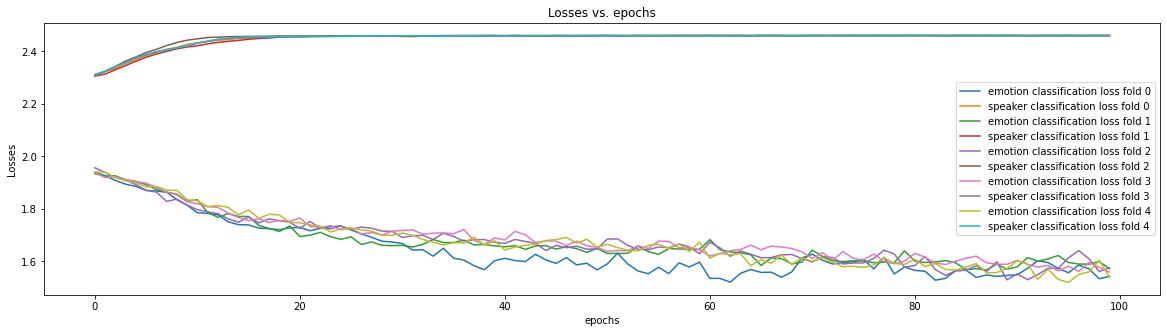

In [14]:
plt.figure(figsize=(20,5))
plt.title('Losses vs. epochs')
plt.xlabel('epochs')
plt.ylabel('Losses')

for i in range(FOLDS):
    plt.plot(range(EPOCHS), fold_emotion_class_losses[i],label='emotion classification loss fold {}'.format(i))
    plt.plot(range(EPOCHS), fold_speaker_class_losses[i],label='speaker classification loss fold {}'.format(i))

plt.legend(loc='best')
plt.show() 

In [15]:
def plot_accuracies_vs_epochs(fold):
    plt.figure(figsize=(20,5))
    plt.title('Accuracies vs. epochs')
    plt.xlabel('epochs')
    plt.ylabel('Losses')
    plt.plot(range(EPOCHS), fold_emotion_training_accuracies[fold],label='emotion_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_emotion_validating_accuracies[fold],label='emotion_validating_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_training_accuracies[fold],label='speaker_training_accuracies fold {}'.format(fold))
    plt.plot(range(EPOCHS), fold_speaker_validating_accuracies[fold],label='speaker_validating_accuracies fold {}'.format(fold))
    plt.legend(loc='best')
    plt.show() 
    print("Maximum emotion training accuracy:{:.2f}%".format(max(fold_emotion_training_accuracies[fold])*100))
    print("Maximum emotion validating accuracy:{:.2f}%".format(max(fold_emotion_validating_accuracies[fold])*100))
    print("Maximum speaker training accuracy:{:.2f}%".format(max(fold_speaker_training_accuracies[fold])*100))
    print("Maximum speaker validating accuracy:{:.2f}%".format(max(fold_speaker_validating_accuracies[fold])*100))

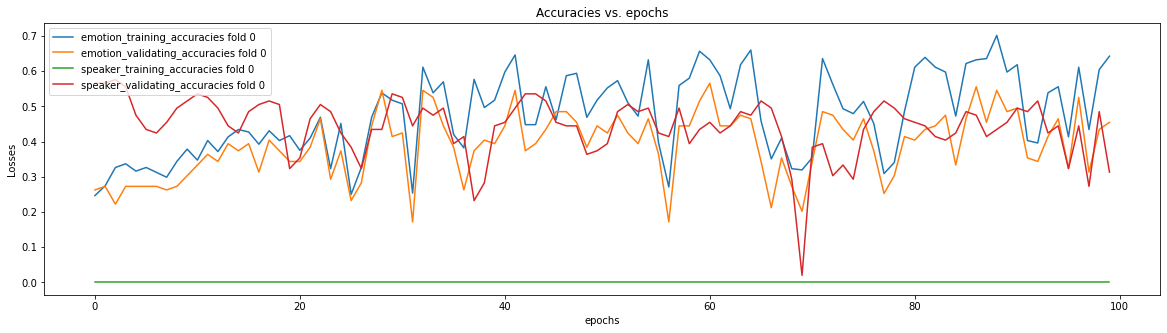

Maximum emotion training accuracy:70.14%
Maximum emotion validating accuracy:56.57%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:57.58%


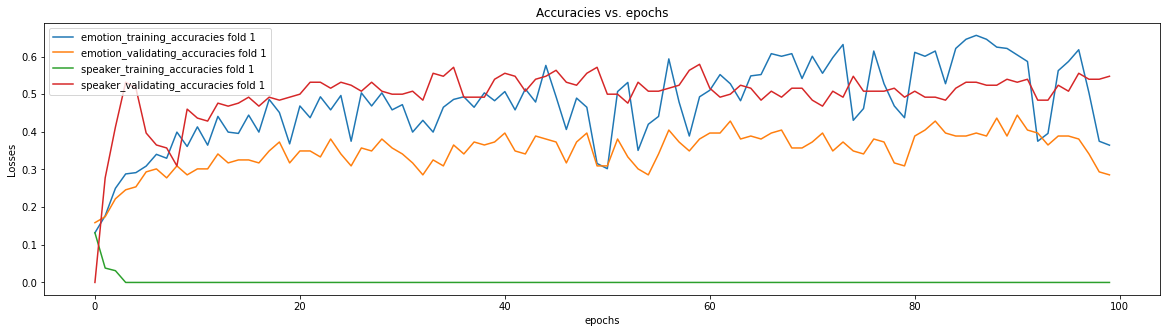

Maximum emotion training accuracy:65.62%
Maximum emotion validating accuracy:44.44%
Maximum speaker training accuracy:13.19%
Maximum speaker validating accuracy:57.94%


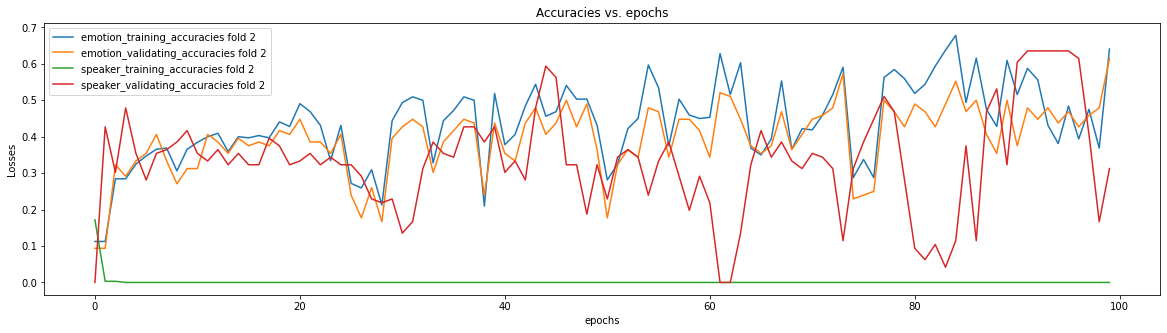

Maximum emotion training accuracy:67.81%
Maximum emotion validating accuracy:61.46%
Maximum speaker training accuracy:17.19%
Maximum speaker validating accuracy:63.54%


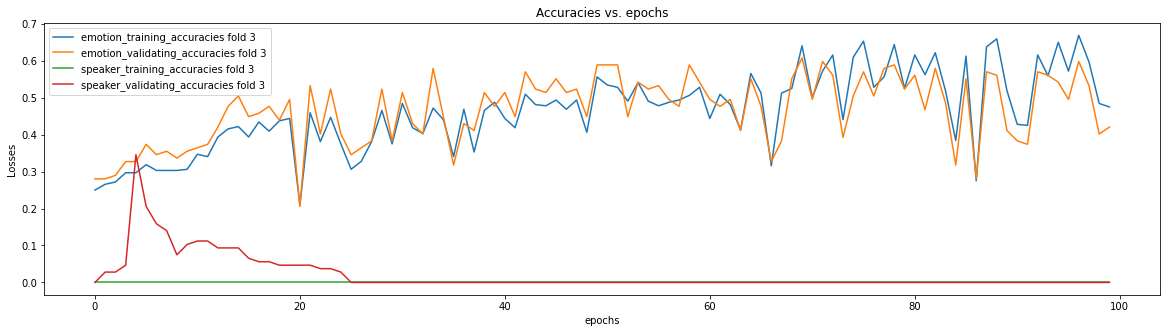

Maximum emotion training accuracy:66.88%
Maximum emotion validating accuracy:60.75%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:34.58%


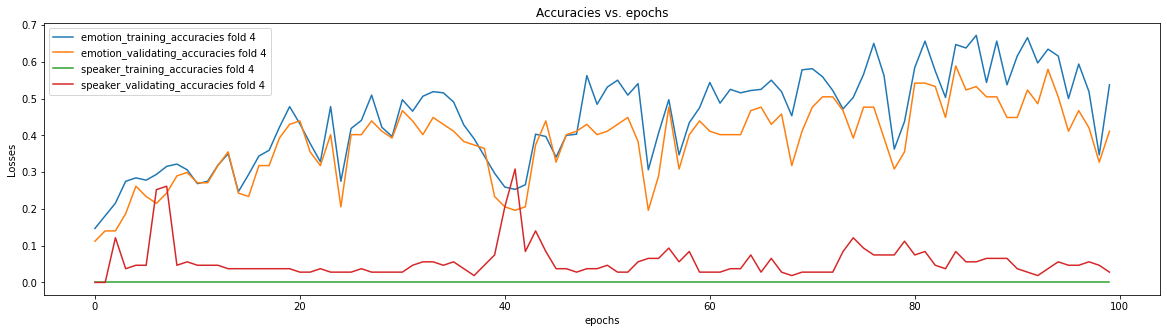

Maximum emotion training accuracy:67.19%
Maximum emotion validating accuracy:58.88%
Maximum speaker training accuracy:0.00%
Maximum speaker validating accuracy:30.84%


In [16]:
for i in range(FOLDS):
    plot_accuracies_vs_epochs(i)

## 5. Loading and evaluating the model

In [17]:
import warnings
warnings.filterwarnings('ignore')
from statistics import mean , stdev
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

lfold_emotion_training_accuracies, lfold_emotion_validating_accuracies, lfold_emotion_testing_accuracies = [] , [] , []
lfold_speaker_training_accuracies, lfold_speaker_validating_accuracies, lfold_speaker_testing_accuracies = [] , [] , []

for fold in range(5):
    print("\nEvaluation for fold {}".format(fold))
    checkpoint = torch.load(MODEL_PATH + 'fold' + str(fold))
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    encoder = FeatureExtractor().to(DEVICE).train()
    emotion_classifier = EmotionClassifier().to(DEVICE).train()
    speaker_classifier = SpeakerClassifier().to(DEVICE)

    encoder_optimizer = torch.optim.Adam(encoder.parameters())
    emotion_optimizer = torch.optim.Adam(emotion_classifier.parameters())
    speaker_optimizer = torch.optim.Adam(speaker_classifier.parameters())
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    emotion_classifier.load_state_dict(checkpoint['emotion_classifier_state_dict'])
    speaker_classifier.load_state_dict(checkpoint['speaker_classifier_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    emotion_optimizer.load_state_dict(checkpoint['emotion_optimizer_state_dict'])
    speaker_optimizer.load_state_dict(checkpoint['speaker_optimizer_state_dict'])
    
    emodb_dataset_train = EmoDBDataset2(ROOT,cv_index = fold ,split= 'train')
    emodb_dataset_test = EmoDBDataset2(ROOT,cv_index = fold, split= 'test')
    emodb_dataset_validate = EmoDBDataset2(ROOT,cv_index = fold, split= 'validate')
    
    TRAIN_BATCH_SIZE = len(emodb_dataset_train)
    VALIDATE_BATCH_SIZE = len(emodb_dataset_validate)
    TEST_BATCH_SIZE = len(emodb_dataset_test)
    
    emodb_train_loader = DataLoader(dataset=emodb_dataset_train, batch_size= TRAIN_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    emodb_validate_loader = DataLoader(dataset=emodb_dataset_validate, batch_size= VALIDATE_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    emodb_test_loader = DataLoader(dataset=emodb_dataset_test, batch_size= TEST_BATCH_SIZE, shuffle=True, drop_last=False,worker_init_fn=np.random.seed(42),num_workers=0)
    
    encoder.eval()
    emotion_classifier.eval()

    lemotion_training_correct, lemotion_validating_correct, lemotion_testing_correct = 0 , 0 , 0
    lspeaker_training_correct, lspeaker_validating_correct, lspeaker_testing_correct = 0 , 0 , 0

    with torch.no_grad():
        

        # 1. Training Classification
        for index, (features, emotion, speaker) in enumerate(emodb_train_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_training_correct += (emotion_preds == emotion).sum() 
            lspeaker_training_correct += (speaker_preds == speaker).sum()
        emotion_training_accuracy = lemotion_training_correct.item()/(len(emodb_train_loader)*TRAIN_BATCH_SIZE)
        speaker_training_accuracy = lspeaker_training_correct.item()/(len(emodb_train_loader)*TRAIN_BATCH_SIZE)
        print("\nEmotion Training Correct: {}/{} \nEmotion Training Accuracy: {:.5f}%".format(lemotion_training_correct,(len(emodb_train_loader)*TRAIN_BATCH_SIZE),emotion_training_accuracy*100))
        print("Speaker Training Correct: {}/{} \nSpeaker Training Accuracy: {:.5f}%".format(lspeaker_training_correct,(len(emodb_train_loader)*TRAIN_BATCH_SIZE),speaker_training_accuracy*100)) 
        
        # 2. Validating Classification
        for index, (features, emotion, speaker) in enumerate(emodb_validate_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_validating_correct += (emotion_preds == emotion).sum() 
            lspeaker_validating_correct += (speaker_preds == speaker).sum()
        emotion_validating_accuracy = lemotion_validating_correct.item()/(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE)
        speaker_validating_accuracy = lspeaker_validating_correct.item()/(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE)
        print("\nEmotion Validating Correct: {}/{} \nEmotion Validating Accuracy: {:.5f}%".format(lemotion_validating_correct,(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE),emotion_validating_accuracy*100))
        print("Speaker Validating Correct: {}/{} \nSpeaker Validating Accuracy: {:.5f}%".format(lspeaker_validating_correct,(len(emodb_validate_loader)*VALIDATE_BATCH_SIZE),speaker_validating_accuracy*100)) 
        

        # 3. Testing Classification
        for index, (features, emotion, speaker) in enumerate(emodb_test_loader):
            features, emotion, speaker = features.to(DEVICE),emotion.to(DEVICE), speaker.to(DEVICE) 
            conv_features = encoder(features)
            emotion_output = emotion_classifier(conv_features)
            speaker_output = speaker_classifier(conv_features)
            _, emotion_preds = torch.max(emotion_output,1)
            _, speaker_preds = torch.max(speaker_output,1)
            lemotion_testing_correct += (emotion_preds == emotion).sum() 
            lspeaker_testing_correct += (speaker_preds == speaker).sum()
        emotion_testing_accuracy = lemotion_testing_correct.item()/(len(emodb_test_loader)*TEST_BATCH_SIZE)
        speaker_testing_accuracy = lspeaker_testing_correct.item()/(len(emodb_test_loader)*TEST_BATCH_SIZE)
        print("\nEmotion Testing Correct: {}/{} \nEmotion Testing Accuracy: {:.5f}%".format(lemotion_testing_correct,(len(emodb_test_loader)*TEST_BATCH_SIZE),emotion_testing_accuracy*100))
        print("Speaker Testing Correct: {}/{} \nSpeaker Testing Accuracy: {:.5f}%".format(lspeaker_testing_correct,(len(emodb_test_loader)*TEST_BATCH_SIZE),speaker_testing_accuracy*100)) 

        lfold_emotion_training_accuracies.append(emotion_training_accuracy)
        lfold_emotion_validating_accuracies.append(emotion_validating_accuracy)
        lfold_emotion_testing_accuracies.append(emotion_testing_accuracy)
        lfold_speaker_training_accuracies.append(speaker_training_accuracy)
        lfold_speaker_validating_accuracies.append(speaker_validating_accuracy)
        lfold_speaker_testing_accuracies.append(speaker_testing_accuracy)

print('\nSUMMARY:')
print('\nCV Emotion Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_training_accuracies), stdev(lfold_emotion_training_accuracies)))
print('\nCV Emotion Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_validating_accuracies), stdev(lfold_emotion_validating_accuracies)))
print('\nCV Emotion Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_emotion_testing_accuracies), stdev(lfold_emotion_testing_accuracies)))

print('\nCV Speaker Training accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_training_accuracies), stdev(lfold_speaker_training_accuracies)))
print('\nCV Speaker Validating accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_validating_accuracies), stdev(lfold_speaker_validating_accuracies)))
print('\nCV Speaker Testing accuracies \nMean: {} \nS.D: {}'.format(mean(lfold_speaker_testing_accuracies), stdev(lfold_speaker_testing_accuracies)))


Evaluation for fold 0



Emotion Training Correct: 199/310 
Emotion Training Accuracy: 64.19355%
Speaker Training Correct: 0/310 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/99 
Emotion Validating Accuracy: 56.56566%
Speaker Validating Correct: 43/99 
Speaker Validating Accuracy: 43.43434%



Emotion Testing Correct: 58/126 
Emotion Testing Accuracy: 46.03175%
Speaker Testing Correct: 21/126 
Speaker Testing Accuracy: 16.66667%

Evaluation for fold 1



Emotion Training Correct: 190/313 
Emotion Training Accuracy: 60.70288%
Speaker Training Correct: 0/313 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 56/126 
Emotion Validating Accuracy: 44.44444%
Speaker Validating Correct: 66/126 
Speaker Validating Accuracy: 52.38095%



Emotion Testing Correct: 45/96 
Emotion Testing Accuracy: 46.87500%
Speaker Testing Correct: 0/96 
Speaker Testing Accuracy: 0.00000%

Evaluation for fold 2



Emotion Training Correct: 213/332 
Emotion Training Accuracy: 64.15663%
Speaker Training Correct: 0/332 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 59/96 
Emotion Validating Accuracy: 61.45833%
Speaker Validating Correct: 25/96 
Speaker Validating Accuracy: 26.04167%



Emotion Testing Correct: 58/107 
Emotion Testing Accuracy: 54.20561%
Speaker Testing Correct: 34/107 
Speaker Testing Accuracy: 31.77570%

Evaluation for fold 3



Emotion Training Correct: 205/321 
Emotion Training Accuracy: 63.86293%
Speaker Training Correct: 0/321 
Speaker Training Accuracy: 0.00000%

Emotion Validating Correct: 65/107 
Emotion Validating Accuracy: 60.74766%
Speaker Validating Correct: 0/107 
Speaker Validating Accuracy: 0.00000%



Emotion Testing Correct: 53/107 
Emotion Testing Accuracy: 49.53271%
Speaker Testing Correct: 56/107 
Speaker Testing Accuracy: 52.33645%

Evaluation for fold 4



Emotion Training Correct: 215/329 
Emotion Training Accuracy: 65.34954%
Speaker Training Correct: 0/329 
Speaker Training Accuracy: 0.00000%



Emotion Validating Correct: 63/107 
Emotion Validating Accuracy: 58.87850%
Speaker Validating Correct: 7/107 
Speaker Validating Accuracy: 6.54206%



Emotion Testing Correct: 49/99 
Emotion Testing Accuracy: 49.49495%
Speaker Testing Correct: 53/99 
Speaker Testing Accuracy: 53.53535%

SUMMARY:

CV Emotion Training accuracies 
Mean: 0.6365310454286798 
S.D: 0.017443766095760566

CV Emotion Validating accuracies 
Mean: 0.5641892051354668 
S.D: 0.06956882575755982

CV Emotion Testing accuracies 
Mean: 0.4922800265674097 
S.D: 0.03189566389371014

CV Speaker Training accuracies 
Mean: 0.0 
S.D: 0.0

CV Speaker Validating accuracies 
Mean: 0.25679803711345767 
S.D: 0.22660602756243156

CV Speaker Testing accuracies 
Mean: 0.30862833946946094 
S.D: 0.23076168884250753
